In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

## Setup

In [2]:
from nba_api.stats.static.players import find_players_by_full_name

In [3]:
harden_data = find_players_by_full_name("James Harden")

In [4]:
harden_id = harden_data[0]['id']

# Comparison with historic top scorers

In [230]:
import requests
from bs4 import BeautifulSoup

In [231]:
def get_urls_for_top_scorers(url):
    res = requests.get(top_scorers_url)
    soup = BeautifulSoup(res.text)
    item = soup.find(attrs={'class': 'stats_table'})
    rows = item.findAll("tr")
    urls = list()
    for row in rows:
        header_cells = row.findAll("th")
        for header_cell in header_cells:
            if 'data-stat' in header_cell.attrs and header_cell['data-stat'] == 'ranker' and 'csk' in header_cell.attrs:
                rank = int(header_cell.getText())
        td_cells = row.findAll("td")
        if not td_cells:
            continue
        for cell in td_cells:
            if 'data-stat' in cell.attrs and cell['data-stat'] == 'season':
                season = int(cell.getText().split("-")[0])+1
            if 'data-stat' in cell.attrs and cell['data-stat'] == 'player':
                url = cell.findAll("a")[0]['href']
        game_log_url = bbref_base + url.split(".")[0] + "/gamelog/" + str(season)
        urls.append(game_log_url)
    return urls

In [232]:
import re

def get_player_name_points(url, limit):
    response = requests.get(url)
    soup = BeautifulSoup(response.text)
    title = soup.find('h1').getText()
    splitted = re.split('\d{4}-\d{2}', title)
    name = splitted[0].strip()
    dash_splitted = title.split('-')
    season = dash_splitted[0].split(" ")[-1] + "-" + dash_splitted[1].split(" ")[0]
    player_names = list()
    seasons = list() # this will be filled with same values
    points = list()
    
    rows = soup.findAll('tr')
    for row in rows:
        cells = row.findAll('td')
        for cell in cells:
            if 'data-stat' in cell.attrs and cell['data-stat'] == 'reason':
                continue
            if 'data-stat' in cell.attrs and cell['data-stat'] == 'game_season':
                if cell.getText() == "":
                    continue
                if int(cell.getText()) > limit:
                    break
            if 'data-stat' in cell.attrs and cell['data-stat'] == 'pts':
                points.append(int(cell.getText()))
                player_names.append(name)
                seasons.append(season)
    
    return player_names, seasons, points

In [233]:
top_scorers_urls = [
    'https://www.basketball-reference.com/players/j/jordami01/gamelog/1987',
    'https://www.basketball-reference.com/players/h/hardeja01/gamelog/2019',
    'https://www.basketball-reference.com/players/b/bryanko01/gamelog/2006',
    'https://www.basketball-reference.com/players/i/iversal01/gamelog/2006',
    'https://www.basketball-reference.com/players/m/mcgratr01/gamelog/2003',
    'https://www.basketball-reference.com/players/d/duranke01/gamelog/2014',
    'https://www.basketball-reference.com/players/w/westbru01/gamelog/2017',
    'https://www.basketball-reference.com/players/j/jamesle01/gamelog/2006',
]

In [234]:
import time
full_names, full_seasons, full_points = [], [], []
harden_total_games = 57
for url in top_scorers_urls:
    print(f"Current url: {url}")
    names, seasons, points = get_player_name_points(url, limit=harden_total_games)
    time.sleep(0.5)
    full_names.extend(names)
    full_seasons.extend(seasons)
    full_points.extend(points)

data_frame = pd.DataFrame(data={
    'PLAYER': full_names,
    'SEASON': full_seasons,
    'POINTS': full_points
})

Current url: https://www.basketball-reference.com/players/j/jordami01/gamelog/1987
Current url: https://www.basketball-reference.com/players/h/hardeja01/gamelog/2019
Current url: https://www.basketball-reference.com/players/b/bryanko01/gamelog/2006
Current url: https://www.basketball-reference.com/players/i/iversal01/gamelog/2006
Current url: https://www.basketball-reference.com/players/m/mcgratr01/gamelog/2003
Current url: https://www.basketball-reference.com/players/d/duranke01/gamelog/2014
Current url: https://www.basketball-reference.com/players/w/westbru01/gamelog/2017
Current url: https://www.basketball-reference.com/players/j/jamesle01/gamelog/2006


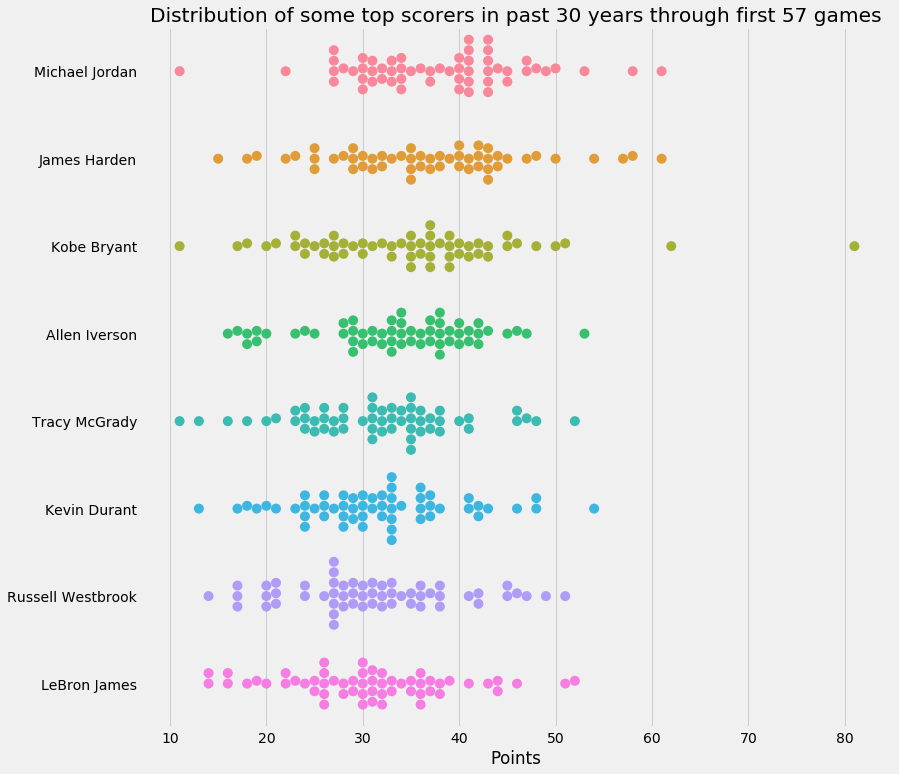

In [237]:
plt.style.use('fivethirtyeight')
fig, ax = plt.subplots(figsize=(12, 12))
sns.swarmplot(y='PLAYER', x='POINTS', data=data_frame, ax=ax, size=10)
# ax.grid(False)
ax.set_xlabel('Points')
ax.set_ylabel('')
_ = ax.set_title('Distribution of some top scorers in past 30 years through first 57 games')
fig.savefig('images/swarmplot.png', bbox_inches='tight')

/home/daniel/.local/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


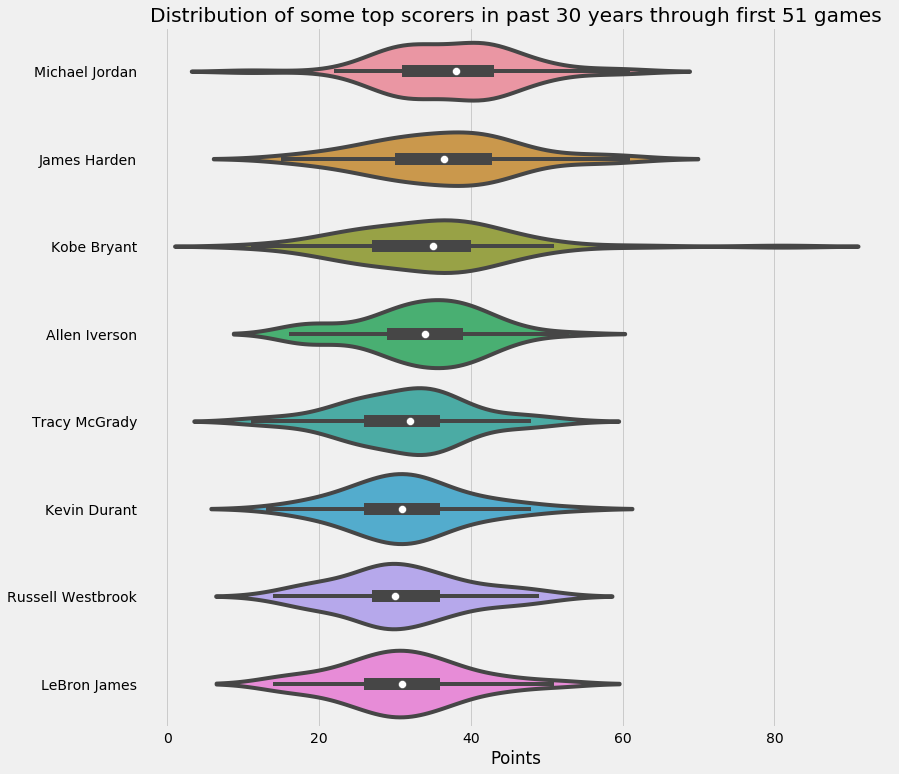

In [238]:
plt.style.use('fivethirtyeight')
fig, ax = plt.subplots(figsize=(12, 12))
sns.violinplot(y='PLAYER', x='POINTS', data=data_frame, ax=ax)

# ax.grid(False)
ax.set_xlabel('Points')
ax.set_ylabel('')
_ = ax.set_title('Distribution of some top scorers in past 30 years through first 51 games')
fig.savefig('images/violinplot.png', bbox_inches='tight')

# Unassisted vs assisted Field goals

In [10]:
from nba_api.stats.endpoints.leaguedashplayerstats import LeagueDashPlayerStats

In [11]:
base_stats = LeagueDashPlayerStats(measure_type_detailed_defense='Base', per_mode_detailed='Totals')

In [12]:
base_df = base_stats.get_data_frames()[0]

In [243]:
scoring_stats = LeagueDashPlayerStats(measure_type_detailed_defense='Scoring')
scoring_df = scoring_stats.get_data_frames()[0]

In [244]:
base_df.loc[:, 'PTS_G'] = base_df.PTS / base_df.GP

In [245]:
base_df = base_df.sort_values(by='PTS', ascending=False)

In [246]:
merged_df = pd.merge(base_df, scoring_df, how='inner', on='PLAYER_ID')

interesting keys: 'PTS', 'FGM', 'FGA', '3FGM', '3FGA', 'PCT_UAST_FGM', 'PCT_AST_FGM'

In [31]:
def calculate_total_uast_ast(data_frame):
    data_frame.loc[:, 'UAST_FGM'] = (data_frame.FGM * data_frame.PCT_UAST_FGM).astype(int, errors='ignore')
    data_frame.loc[:, 'AST_FGM'] = (data_frame.FGM * data_frame.PCT_AST_FGM).astype(int, errors='ignore')
    
    data_frame.loc[:, 'UAST_FG3M'] = (data_frame.FG3M * data_frame.PCT_UAST_3PM).astype(int, errors='ignore')
    data_frame.loc[:, 'AST_FG3M'] = (data_frame.FG3M * data_frame.PCT_AST_3PM).astype(int, errors='ignore')
    
    
    return data_frame

In [248]:
total_merged_df = calculate_total_uast_ast(merged_df)

In [249]:
top_150_scorers_df = total_merged_df.iloc[:250]

In [250]:
top_scorers = top_150_scorers_df.iloc[:15]

In [251]:
from adjustText import adjust_text

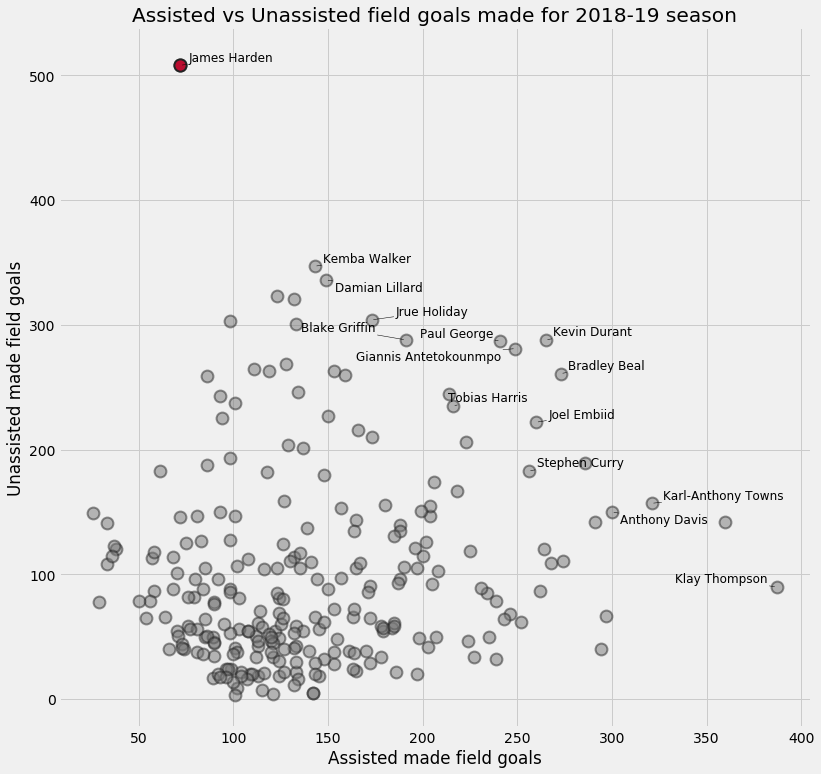

In [252]:
plt.style.use('fivethirtyeight')
fig, ax = plt.subplots(figsize=(12, 12))

ax.scatter(
    x=top_150_scorers_df.AST_FGM,
    y=top_150_scorers_df.UAST_FGM,
    s=140, color="#787878", alpha=0.5, linewidths=2, edgecolors="#232323")

texts = []
for i in range(len(top_scorers)):
    item = top_scorers.iloc[i]
    texts.append(ax.text(x=item.AST_FGM, y=item.UAST_FGM, s=item.PLAYER_NAME_x, fontsize=12))
    if item.PLAYER_NAME_x == 'James Harden':
        ax.scatter(x=item.AST_FGM, y=item.UAST_FGM, s=150, color="#BA0C2F", alpha=1.0, linewidths=2.0, edgecolors="#232323")

adjust_text(texts, arrowprops=dict(arrowstyle='-', color='black'), expand_points=(1.2, 1.2), expand_text=(1.3, 1.3))

ax.set_xlabel("Assisted made field goals")
ax.set_ylabel("Unassisted made field goals")
ax.set_title("Assisted vs Unassisted field goals made for 2018-19 season")
fig.savefig('images/ast_unast_2018_19.png', bbox_inches='tight')

## Three point shots

In [253]:
top_150_three = total_merged_df.sort_values(by='FG3M', ascending=False).iloc[:150]

In [254]:
top_shooters = top_150_three.iloc[:10]

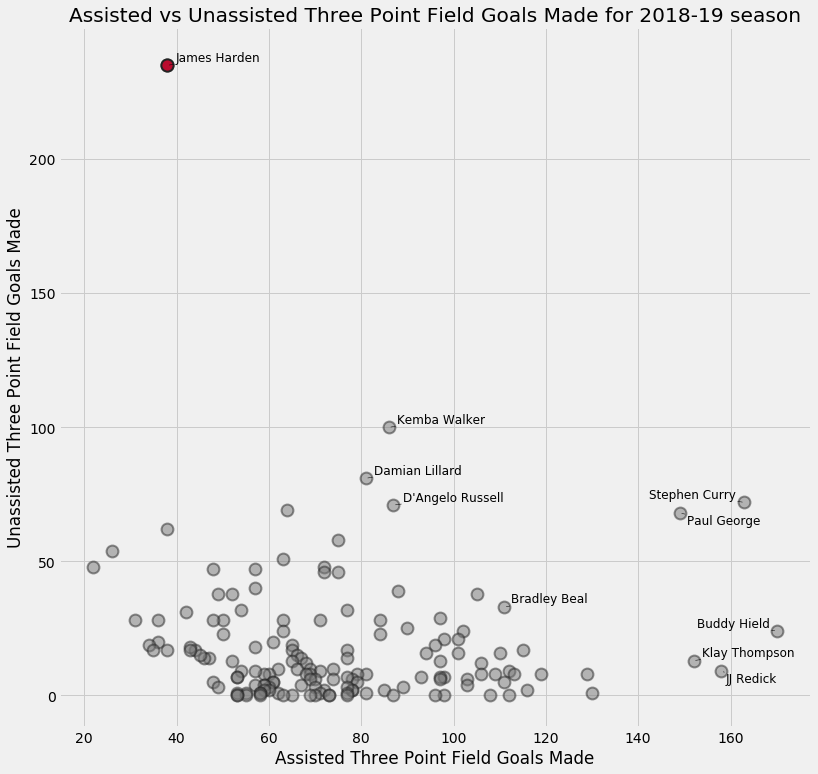

In [436]:
plt.style.use('fivethirtyeight')
fig, ax = plt.subplots(figsize=(12, 12))

ax.scatter(
    x=top_150_three.AST_FG3M,
    y=top_150_three.UAST_FG3M,
    s=140, color="#787878", alpha=0.5, linewidths=2, edgecolors="#232323")

texts = []
for i in range(len(top_shooters)):
    item = top_shooters.iloc[i]
    texts.append(ax.text(x=item.AST_FG3M, y=item.UAST_FG3M, s=item.PLAYER_NAME_x, fontsize=12))
    if item.PLAYER_NAME_x == 'James Harden':
        ax.scatter(x=item.AST_FG3M, y=item.UAST_FG3M, s=150, color="#BA0C2F", alpha=1.0, linewidths=2.0, edgecolors="#232323")

adjust_text(texts, arrowprops=dict(arrowstyle='-', color='black'), expand_points=(1.2, 1.2), expand_text=(1.3, 1.3))

ax.set_xlabel("Assisted Three Point Field Goals Made")
ax.set_ylabel("Unassisted Three Point Field Goals Made")
_ = ax.set_title("Assisted vs Unassisted Three Point Field Goals Made for 2018-19 season")
fig.savefig('images/ast_unast_fg3_2018_19.png', bbox_inches='tight')

## Three pointers since 1999-00

In [5]:
import time

In [6]:
seasons = list(range(1999, 2019))

In [7]:
seasons = [f"{season}-{str(season+1)[-2:]}" for season in seasons]

In [448]:
complete_df = None
for season in seasons:
    base_df = LeagueDashPlayerStats(
        measure_type_detailed_defense='Base',
        per_mode_detailed='Totals',
        season=season,
        season_segment_nullable="Pre All-Star",
    ).get_data_frames()[0]
    time.sleep(1)
    
    scoring_stats = LeagueDashPlayerStats(measure_type_detailed_defense='Scoring', season=season,
                                          season_segment_nullable="Pre All-Star")
    scoring_df = scoring_stats.get_data_frames()[0]
    time.sleep(1)
    
    base_df.loc[:, 'PTS_G'] = base_df.PTS / base_df.GP
    base_df = base_df.sort_values(by='FG3M', ascending=False)
    merged_df = pd.merge(base_df, scoring_df, how='inner', on='PLAYER_ID')
    total_merged_df = calculate_total_uast_ast(merged_df)
    total_merged_df.loc[:, "SEASON"] = season
    top_15_three_shot = total_merged_df.iloc[:15]
    
    if complete_df is None:
        complete_df = top_15_three_shot
    else:
        complete_df = pd.concat([complete_df, top_15_three_shot], ignore_index=True)
    print(f"Done with {season}")

Done with 1999-00
Done with 2000-01
Done with 2001-02
Done with 2002-03
Done with 2003-04
Done with 2004-05
Done with 2005-06
Done with 2006-07
Done with 2007-08
Done with 2008-09
Done with 2009-10
Done with 2010-11
Done with 2011-12
Done with 2012-13
Done with 2013-14
Done with 2014-15
Done with 2015-16
Done with 2016-17
Done with 2017-18
Done with 2018-19


In [ ]:
complete_df.FG3M

In [452]:
sorted_df = complete_df.sort_values(by='FG3M', ascending=False)

In [465]:
top_10_shooters = sorted_df.iloc[:10] 

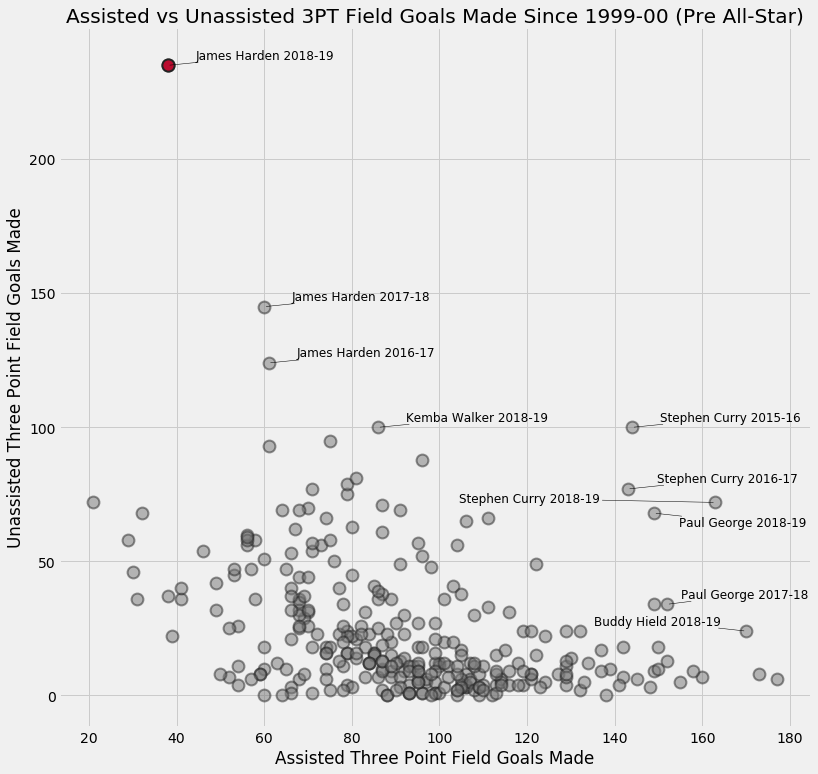

In [466]:
plt.style.use('fivethirtyeight')
fig, ax = plt.subplots(figsize=(12, 12))

ax.scatter(
    x=complete_df.AST_FG3M,
    y=complete_df.UAST_FG3M,
    s=140, color="#787878", alpha=0.5, linewidths=2, edgecolors="#232323")

texts = []


for i in range(len(top_10_shooters)):
    item = top_10_shooters.iloc[i]
    text = item.PLAYER_NAME_x + " " + item.SEASON
    texts.append(ax.text(x=item.AST_FG3M, y=item.UAST_FG3M, s=text, fontsize=12))
    if item.PLAYER_NAME_x == 'James Harden' and item.SEASON == '2018-19':
        ax.scatter(x=item.AST_FG3M, y=item.UAST_FG3M, s=150, color="#BA0C2F", alpha=1.0, linewidths=2.0, edgecolors="#232323")

adjust_text(texts, arrowprops=dict(arrowstyle='-', color='black'), expand_points=(1.4, 1.5), expand_text=(1.3, 1.5))

ax.set_xlabel("Assisted Three Point Field Goals Made")
ax.set_ylabel("Unassisted Three Point Field Goals Made")
_ = ax.set_title("Assisted vs Unassisted 3PT Field Goals Made Since 1999-00 (Pre All-Star)")
fig.savefig('images/ast_unast_fg3_since_00.png', bbox_inches='tight')

## Top scorers since 1999-00 and their ast/unast ratio

In [32]:
from nba_api.stats.endpoints.leaguedashplayerstats import LeagueDashPlayerStats

In [33]:
complete_df = None
for season in seasons:
    base_df = LeagueDashPlayerStats(
        measure_type_detailed_defense='Base',
        per_mode_detailed='Totals',
        season=season,
        season_segment_nullable="Pre All-Star",
    ).get_data_frames()[0]
    time.sleep(1)
    
    scoring_stats = LeagueDashPlayerStats(measure_type_detailed_defense='Scoring', season=season,
                                          season_segment_nullable="Pre All-Star")
    scoring_df = scoring_stats.get_data_frames()[0]
    time.sleep(1)
    
    base_df.loc[:, 'PTS_G'] = base_df.PTS / base_df.GP
    base_df = base_df.sort_values(by='PTS', ascending=False)
    merged_df = pd.merge(base_df, scoring_df, how='inner', on='PLAYER_ID')
    total_merged_df = calculate_total_uast_ast(merged_df)
    total_merged_df.loc[:, "SEASON"] = season
    top_15_scorers = total_merged_df.iloc[:15]
    
    if complete_df is None:
        complete_df = top_15_scorers
    else:
        complete_df = pd.concat([complete_df, top_15_scorers], ignore_index=True)
    print(f"Done with {season}")

Done with 1999-00
Done with 2000-01
Done with 2001-02
Done with 2002-03
Done with 2003-04
Done with 2004-05
Done with 2005-06
Done with 2006-07
Done with 2007-08
Done with 2008-09
Done with 2009-10
Done with 2010-11
Done with 2011-12
Done with 2012-13
Done with 2013-14
Done with 2014-15
Done with 2015-16
Done with 2016-17
Done with 2017-18
Done with 2018-19


In [54]:
sorted_df = complete_df.sort_values(by='PTS', ascending=False)

In [78]:
top_10_shooters = sorted_df.iloc[:10] 

In [88]:
top_10_shooters

,PLAYER_ID,PLAYER_NAME_x,TEAM_ID_x,TEAM_ABBREVIATION_x,AGE_x,GP_x,W_x,L_x,W_PCT_x,MIN_x,...,PCT_UAST_3PM_RANK,PCT_AST_FGM_RANK,PCT_UAST_FGM_RANK,CFID_y,CFPARAMS_y,UAST_FGM,AST_FGM,UAST_FG3M,AST_FG3M,SEASON
285,201935,James Harden,1.610613e+09,HOU,29.0,54,32,22,0.593,2019.458333,...,7,484,4,5,"201935,1610612745",508,72,235,38,2018-19
255,201566,Russell Westbrook,1.610613e+09,OKC,28.0,57,32,25,0.561,1974.286667,...,9,446,14,5,"201566,1610612760",466,108,78,45,2016-17
90,977,Kobe Bryant,1.610613e+09,LAL,27.0,50,26,24,0.520,2036.511667,...,38,372,61,5,"977,1610612747",355,240,35,68,2005-06
210,201142,Kevin Durant,1.610613e+09,OKC,25.0,54,42,12,0.778,2060.568333,...,24,356,94,5,"201142,1610612760",306,251,53,66,2013-14
256,201935,James Harden,1.610613e+09,HOU,27.0,58,40,18,0.690,2123.311667,...,6,447,13,5,"201935,1610612745",394,88,124,61,2016-17
91,2544,LeBron James,1.610613e+09,CLE,21.0,52,31,21,0.596,2195.771667,...,12,401,32,5,"2544,1610612739",391,184,50,36,2005-06
150,2544,LeBron James,1.610613e+09,CLE,25.0,54,43,11,0.796,2097.811667,...,6,389,42,5,"2544,1610612739",350,194,68,32,2009-10
286,202331,Paul George,1.610613e+09,OKC,28.0,56,36,20,0.643,2033.468333,...,60,402,86,5,"202331,1610612760",287,241,68,149,2018-19
92,947,Allen Iverson,1.610613e+09,PHI,31.0,48,23,25,0.479,2079.370000,...,36,419,14,5,"947,1610612755",430,129,17,29,2005-06
257,202738,Isaiah Thomas,1.610613e+09,BOS,28.0,53,36,17,0.679,1829.773333,...,47,372,88,5,"202738,1610612738",282,209,65,106,2016-17


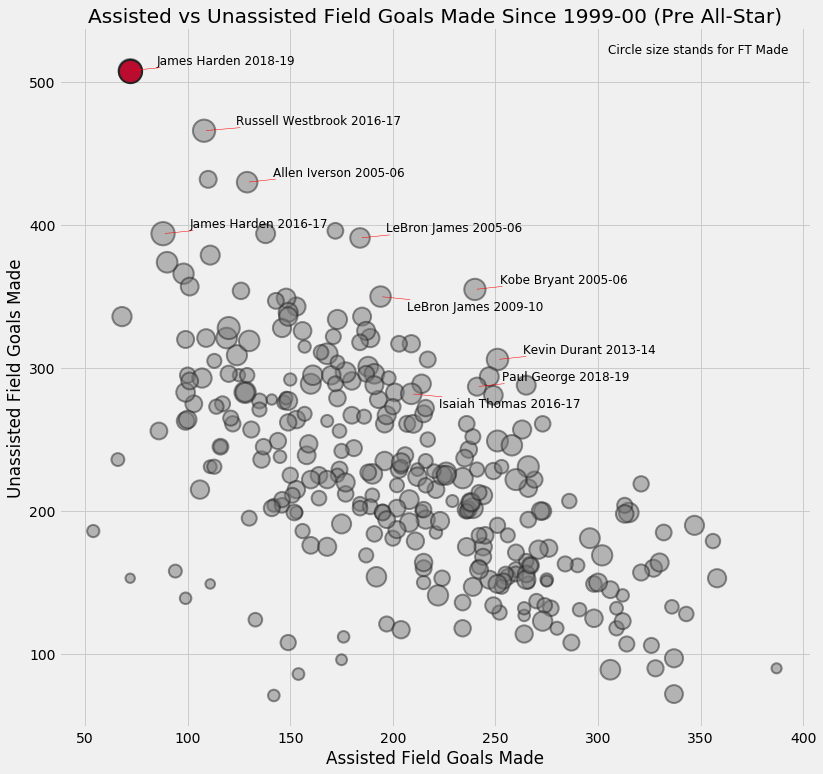

In [79]:
plt.style.use('fivethirtyeight')
fig, ax = plt.subplots(figsize=(12, 12))

ax.scatter(
    x=complete_df.AST_FGM,
    y=complete_df.UAST_FGM,
    s=complete_df.FTM, color="#787878", alpha=0.5, linewidths=2, edgecolors="#232323")

texts = []


for i in range(len(top_10_shooters)):
    item = top_10_shooters.iloc[i]
    text = item.PLAYER_NAME_x + " " + item.SEASON
    texts.append(ax.text(x=item.AST_FGM, y=item.UAST_FGM, s=text, fontsize=12))
    if item.PLAYER_NAME_x == 'James Harden' and item.SEASON == '2018-19':
        ax.scatter(x=item.AST_FGM, y=item.UAST_FGM, s=item.FTM, color="#BA0C2F", alpha=1.0, linewidths=2.0, edgecolors="#232323")

adjust_text(texts, arrowprops=dict(arrowstyle='-', color='red'), expand_points=(1.4, 1.5), expand_text=(1.3, 1.5))

ax.set_xlabel("Assisted Field Goals Made")
ax.set_ylabel("Unassisted Field Goals Made")
_ = ax.set_title("Assisted vs Unassisted Field Goals Made Since 1999-00 (Pre All-Star)")
ax.text(x=305, y=520, s="Circle size stands for FT Made", fontsize=12)
fig.savefig('images/ast_unast_fgm_since_00.png', bbox_inches='tight')

# Usage and efficiency

While Harden is having tremendously high scoring season, how efficient is he? And how big is his usage? I'll take on that in next couple of cells.

In [14]:
from nba_api.stats.endpoints.leaguedashplayerstats import LeagueDashPlayerStats

In [15]:
basic_stats = LeagueDashPlayerStats()
basic_df = basic_stats.get_data_frames()[0]

In [16]:
advanced_stats = LeagueDashPlayerStats(measure_type_detailed_defense="Advanced")

In [17]:
advanced_df = advanced_stats.get_data_frames()[0]

In [18]:
advanced_df_filtered = advanced_df.loc[advanced_df.GP > 20]

In [19]:
advanced_df_filtered = advanced_df_filtered.sort_values(by="USG_PCT", ascending=False)

In [20]:
from numpy.polynomial.polynomial import polyfit

In [21]:
merged_df = pd.merge(basic_df, advanced_df, on='PLAYER_ID')

In [22]:
filtered_data = merged_df.sort_values(by='PTS', ascending=False)
filtered_data = filtered_data.iloc[:200]

In [140]:
filtered_data.loc[:, 'PTS_G'] = filtered_data.PTS / filtered_data.GP_x

In [173]:
filtered_data = pd.read_csv('usg_2018_19.csv')

In [178]:
filter_out_harden = filtered_data.loc[filtered_data.Player == 'James Harden']

In [179]:
from adjustText import adjust_text

In [180]:
top_10 = filtered_data.sort_values(by='PTS', ascending=False).iloc[:10]

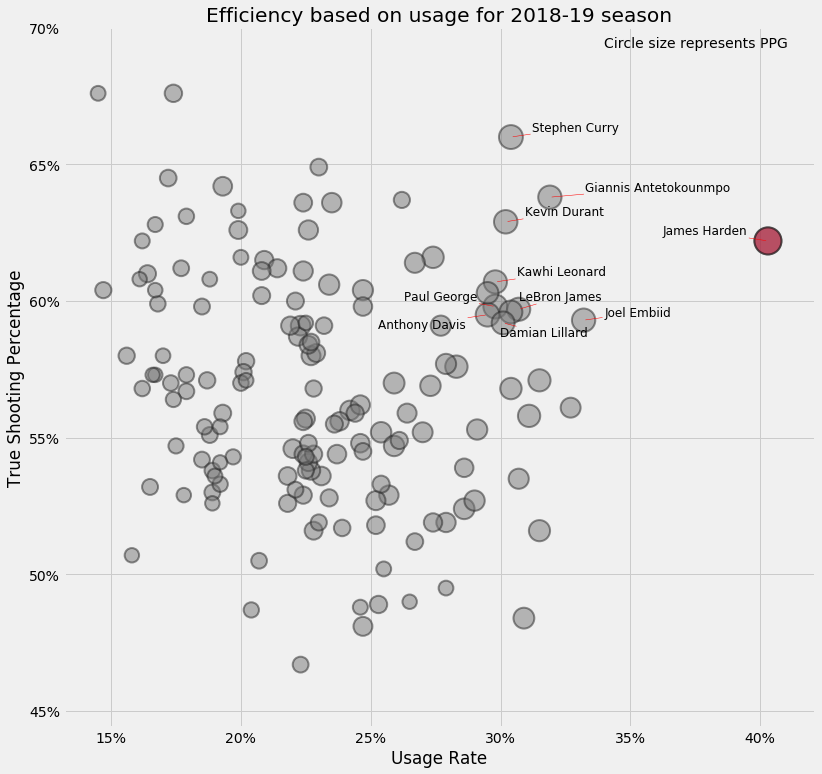

In [187]:

plt.style.use('fivethirtyeight')
fig, ax = plt.subplots(figsize=(12, 12))


ax.scatter(x=filtered_data.USG_PCT, y=filtered_data.TS_PCT, s=filtered_data.PTS * 20, alpha=0.5, linewidths=2.0, edgecolors="#232323", color="#787878")

ax.scatter(x=filter_out_harden.USG_PCT, y=filter_out_harden.TS_PCT, s=filtered_data.PTS * 20, linewidths=2.0, color="#BA0C2F",edgecolors="#232323", alpha=0.6)

texts = [ax.text(x=filter_out_harden.USG_PCT.iloc[0], y=filter_out_harden.TS_PCT.iloc[0], s="James Harden", fontsize=12)]
for i in range(len(top_10)):
    item = top_10.iloc[i]
    if item.Player == 'James Harden':
        continue
    texts.append(ax.text(x=item.USG_PCT, y=item.TS_PCT, s=item.Player, fontsize=12))

adjust_text(texts, expand_points=(1.5, 1.5), arrowprops=dict(arrowstyle='-', color='red'))
ax.set_yticklabels(["{0:.0f}%".format(item*100) for item in ax.get_yticks()])
ax.set_xticklabels(["{0:.0f}%".format(item) for item in ax.get_xticks()])
# ax.set_yticklabels()
ax.set_xlabel('Usage Rate')
ax.set_ylabel('True Shooting Percentage')
ax.set_title('Efficiency based on usage for 2018-19 season')
ax.text(x=34, y=0.693, s="Circle size represents PPG")
fig.savefig('images/efficiency_2018_19.png', bbox_inches='tight')

### Top scorers in three point era

Here I took a look at top 100 scorers in three point era, and how they efficient they were with more workload on their back.

In [403]:
data_frame = pd.read_csv('top_100_3pt_era.csv')

In [404]:
harden_only = data_frame.loc[(data_frame.Player == 'James Harden') & (data_frame.Season == '2018-19')]

In [405]:
from numpy.polynomial.polynomial import polyfit

In [406]:
usages = np.array(data_frame.USG_PCT)
square_usages = usages ** 2

b, m1, m2 = polyfit(data_frame.USG_PCT, data_frame.TS_PCT, deg=2)

In [407]:
x_usages = np.linspace(int(data_frame.USG_PCT.min()), int(data_frame.USG_PCT.max())+1, 100)
square_usages = x_usages ** 2

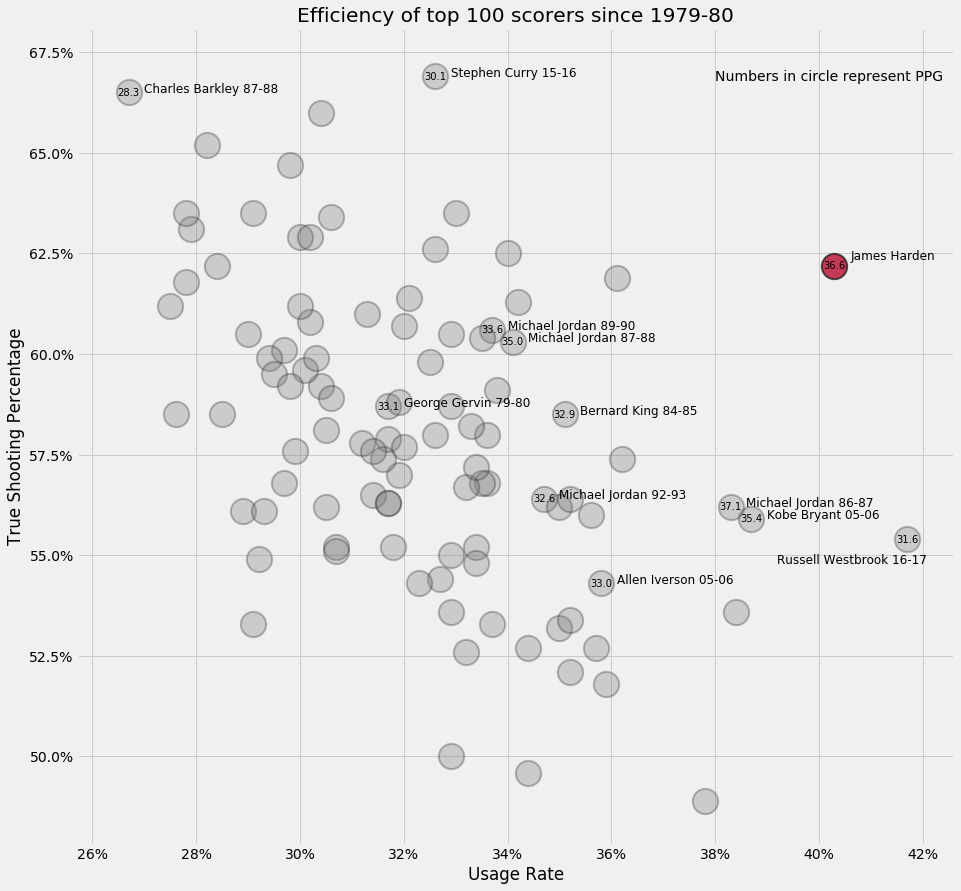

In [408]:
plt.style.use('fivethirtyeight')
fig, ax = plt.subplots(figsize=(14, 14))


# ax.plot(x_usages, b + m1 * x_usages + m2 * square_usages, color="#CA5545", alpha=0.5)

texts=[]
for i in range(len(data_frame)):
    item = data_frame.iloc[i]
    if item.Player == 'James Harden' and item.Season == '2018-19':
        ax.scatter(x=item.USG_PCT, y=item.TS_PCT, s=640, linewidths=2.0, color="#BA0C2F", alpha=0.8, edgecolors="#232323")
        text = [ax.text(x=item.USG_PCT, y=item.TS_PCT, s="James Harden", fontsize=12)]
        ax.text(x=item.USG_PCT, y=item.TS_PCT, s=item.PTS, fontsize=10, ha='center', va='center')
        continue
    ax.scatter(x=item.USG_PCT, y=item.TS_PCT, s=640, alpha=0.3, linewidths=2.0, edgecolors="#232323", color="#787878")
    if item.Rk < 10 or item.TS_PCT > 0.66 or item.USG_PCT > 40:
        season = item.Season[-5:]
        name = item.Player
        points = item.PTS
        if name == "Russell Westbrook":
            texts.append(ax.text(x=item.USG_PCT + - 2.5, y=item.TS_PCT -0.006, s=name + " " + season, fontsize=12))
        else:
            texts.append(ax.text(x=item.USG_PCT + 0.3, y=item.TS_PCT, s=name + " " + season, fontsize=12))
        ax.text(x=item.USG_PCT, y=item.TS_PCT, s=points, fontsize=10, ha='center', va='center')

adjust_text(texts=text, expand_points=(1.4, 1.4))

ax.set_yticklabels(["{0:.1f}%".format(item*100) for item in ax.get_yticks()])
ax.set_xticklabels(["{0:.0f}%".format(item) for item in ax.get_xticks()])
ax.set_xlabel('Usage Rate')
ax.set_ylabel('True Shooting Percentage')
ax.set_title('Efficiency of top 100 scorers since 1979-80')
ax.text(x=38, y=0.668, s="Numbers in circle represent PPG")

fig.savefig('images/efficiency_top_scorers_no_reg.png', bbox_inches='tight')

# Touches and possession time

In [89]:
from nba_api.stats.endpoints.leaguedashptstats import LeagueDashPtStats

In [90]:
touches = LeagueDashPtStats(per_mode_simple="PerGame", pt_measure_type="Possessions", player_or_team='Player')
touches_guards = LeagueDashPtStats(
    per_mode_simple="PerGame",
    pt_measure_type="Possessions",
    player_or_team='Player',
    player_position_abbreviation_nullable='G'
)

In [91]:
touches_df = touches.get_data_frames()[0]
touches_guards_df = touches_guards.get_data_frames()[0]

In [92]:
touches_df = touches_df.sort_values(by="POINTS", ascending=False).iloc[:250]

In [93]:
touches_df = touches_df.loc[touches_df.GP > 20]
touches_df = touches_df.loc[touches_df.GP * touches_df.TOUCHES > 500]

In [94]:
touches_guards_df = touches_guards_df.loc[touches_guards_df.GP > 20]
touches_guards_df = touches_guards_df.loc[touches_guards_df.GP * touches_guards_df.TOUCHES > 500]

In [95]:
houston_players = touches_df.loc[(touches_df.TEAM_ABBREVIATION == "HOU") & (touches_df.PLAYER_NAME != "James Harden")]

In [96]:
harden_df = touches_df.loc[touches_df.PLAYER_NAME == "James Harden"]

In [97]:
hou_ids = houston_players.PLAYER_ID.tolist() + harden_df.PLAYER_ID.tolist()

In [98]:
without_hou = touches_df.loc[~touches_df.PLAYER_ID.isin(hou_ids)]
touches_guards_df = touches_guards_df.loc[~touches_guards_df.PLAYER_ID.isin(hou_ids)]

In [99]:
plot_guards = False

In [100]:
top_10_scorers = touches_df.iloc[:10]

In [101]:
from adjustText import adjust_text
plt.style.use('fivethirtyeight')

In [102]:
from numpy.polynomial.polynomial import polyfit

b, m1 = polyfit(touches_df.AVG_DRIB_PER_TOUCH, touches_df.PTS_PER_TOUCH, deg=1)
x_values = np.linspace(
    int(touches_df.AVG_DRIB_PER_TOUCH.min()), int(touches_df.AVG_DRIB_PER_TOUCH.max()+1), 100
)

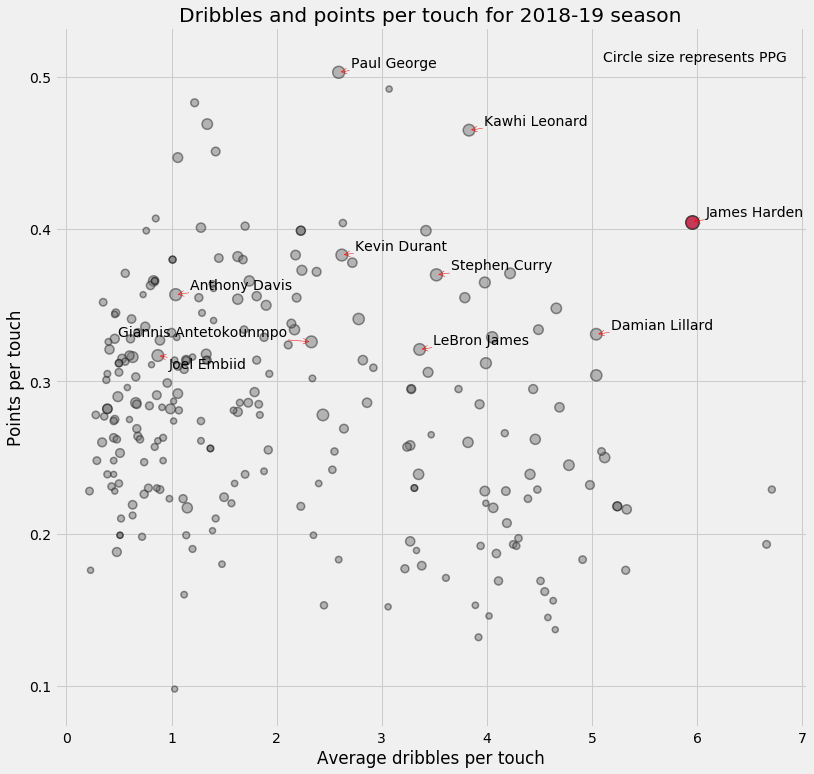

In [108]:

fig, ax = plt.subplots(figsize=(12, 12))

size = 250

ax.scatter(
    x=without_hou.AVG_DRIB_PER_TOUCH,
    y=without_hou.PTS_PER_TOUCH,
    s=without_hou.POINTS * 5,
    alpha=0.5,
    color="#787878",
    edgecolors="#232323",
    linewidths=1.5,
)

if plot_guards:
    ax.scatter(
        x=touches_guards_df.AVG_DRIB_PER_TOUCH,
        y=touches_guards_df.PTS_PER_TOUCH,
        s=touches_guards_df.TOUCHES * 5,
        alpha=0.8,
        color="#EFF0D1",
        edgecolors="#232323",
        linewidths=1.5,
    )

ax.scatter(
    x=houston_players.AVG_DRIB_PER_TOUCH,
    y=houston_players.PTS_PER_TOUCH,
    s=houston_players.POINTS * 5,
    alpha=0.8,
    color="#787878",
    edgecolors="#232323",
    linewidths=1.5,
)

ax.scatter(
    x=harden_df.AVG_DRIB_PER_TOUCH,
    y=harden_df.PTS_PER_TOUCH,
    s=harden_df.POINTS * 5,
    color="#BA0C2F",
    linewidths=1.5,
    alpha=0.8,
    edgecolors="#232323",
)

# ax.plot(x_values, b + m1 * x_values, color="#AE2525", alpha=0.5)

texts = []

for i in range(len(top_10_scorers)):
    item = top_10_scorers.iloc[i]
    texts.append(
        ax.text(
            x=item.AVG_DRIB_PER_TOUCH,
            y=item.PTS_PER_TOUCH,
            s=item.PLAYER_NAME
        )
    )
    
adjust_text(texts, arrowprops=dict(arrowstyle='->', color='red'), expand_points=(1.3, 1.3))


ax.set_xlabel("Average dribbles per touch")
ax.set_ylabel("Points per touch")
_ = ax.set_title("Dribbles and points per touch for 2018-19 season")
ax.text(x=5.1, y=0.51, s="Circle size represents PPG")

fig.savefig('images/dribbles_points_bubble.png', bbox_inches='tight')


Notes:

Generally Players with more points per touch don't have as much dribbles per touch because those players usually point guards (meaning they control the offense and usually carry the ball through court). But Harden is exception in that and he is "soloing" more as can be seen here. 
He doesn't rely on teammates to feed him the ball but he rather creates shots for himself.

# Analyzing scoring preferences 

### Based on type of play

We will use tracking data from stats.nba.com and plot parallel plot to compare some of the top scorers and how they get their buckets.

In [5]:
from nba_api.stats.endpoints.leaguedashptstats import LeagueDashPtStats

In [6]:
league_stats = LeagueDashPtStats(pt_measure_type='Efficiency', player_or_team="Player", per_mode_simple="PerGame")

In [7]:
scoring_type_df = league_stats.get_data_frames()[0]

In [8]:
def filter_data_frame(data_frame):
    interesting_columns = [
        'PLAYER_NAME',
        'ELBOW_TOUCH_PTS',
        'POST_TOUCH_PTS',
        'PAINT_TOUCH_PTS',
        'DRIVE_PTS',
        'PULL_UP_PTS',
        'CATCH_SHOOT_PTS',
    ]

    filtered_df = data_frame.sort_values(by='POINTS', ascending=False)
    
    filtered_df = filtered_df[interesting_columns]
    filtered_df = filtered_df[
        [
            'PLAYER_NAME',
            'ELBOW_TOUCH_PTS',
            'POST_TOUCH_PTS',
            'PAINT_TOUCH_PTS',
            'DRIVE_PTS',
            'PULL_UP_PTS',
            'CATCH_SHOOT_PTS',
        ]
    ]
    return filtered_df

In [9]:
# Filter and reorder the columns
filtered_df = filter_data_frame(scoring_type_df)

In [10]:
melted_df = pd.melt(filtered_df.iloc[:50], id_vars='PLAYER_NAME')

In [11]:
players = melted_df.PLAYER_NAME.unique()

In [12]:
plt.style.use('fivethirtyeight')

In [13]:
color_mappings = {
    'James Harden': '#BA0C2F',
    'Giannis Antetokounmpo': '#00471B',
    'Stephen Curry': '#FDB927',
    'Joel Embiid': '#040204',
    'Paul George': '#007AC1',
}

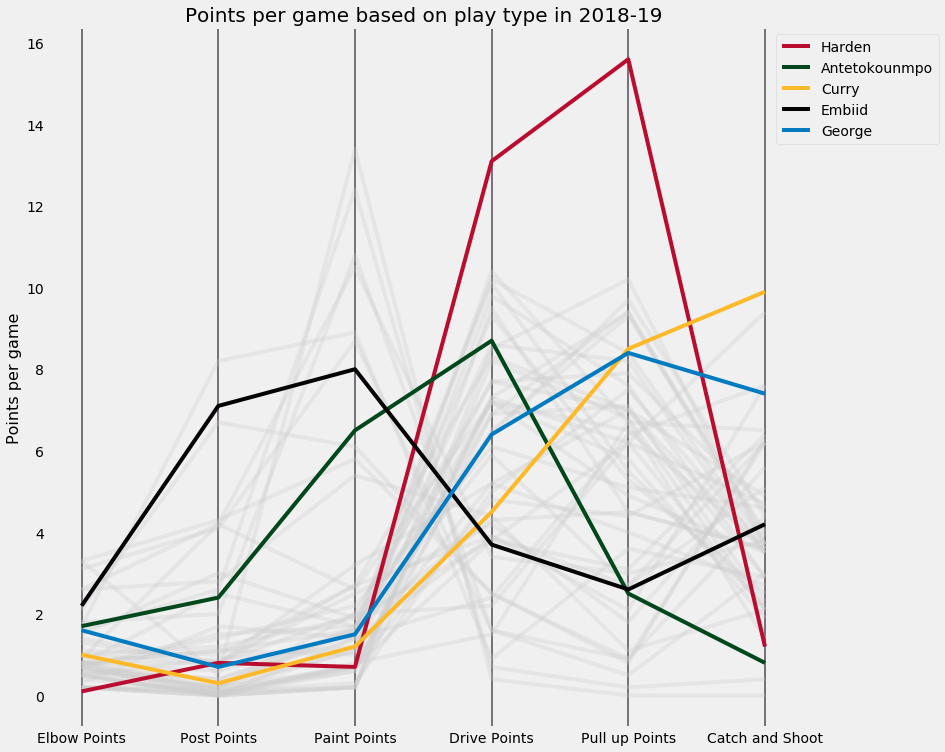

In [38]:
fig, ax = plt.subplots(figsize=(12, 12))


for player_name in players:
    if player_name in color_mappings:
        continue
    current_player_data = melted_df.loc[melted_df.PLAYER_NAME == player_name]
    ax.plot('variable', 'value', data=current_player_data, color='#CDCDCD', alpha=0.3, label="")
    
for player_name in color_mappings:
    current_player_data = melted_df.loc[melted_df.PLAYER_NAME == player_name]
    color = color_mappings[player_name]
    ax.plot('variable', 'value', data=current_player_data, color=color, alpha=1.0, label=player_name.split(" ")[1])
ax.set_ylabel("Points per game", size=16)
ax.set_title("Points per game based on play type in 2018-19", size=20)
    
ax.set_xticklabels([
    "Elbow Points",
    "Post Points",
    "Paint Points",
    "Drive Points",
    "Pull up Points",
    "Catch and Shoot"
])

ax.grid(False, axis='y')
ax.grid(True, axis='x', color='#544953', linewidth=1.5)
ax.legend(bbox_to_anchor=(0.96, 1))
fig.savefig('images/scoring_type.png', bbox_inches='tight')

In [31]:
def plot_others(ax, players, target_player, melted_df):
    for player_name in players:
        if player_name == target_player:
            continue
        current_player_data = melted_df.loc[melted_df.PLAYER_NAME == player_name]
        ax.plot('variable', 'value', data=current_player_data, color='#CDCDCD', alpha=0.3, label="")
        
def plot_single_player(ax, player_name, color_mappings, melted_df):
    current_player_data = melted_df.loc[melted_df.PLAYER_NAME == player_name]
    color = color_mappings[player_name]
    ax.plot('variable', 'value', data=current_player_data, color=color, alpha=1.0, label=player_name)
    
def set_ticks_labels(ax, player):
    ax.set_ylabel("Points per game", size=16)
    ax.set_title(player, size=20)

    ax.set_xticklabels([
        "Elbow Points",
        "Post Points",
        "Paint Points",
        "Drive Points",
        "Pull up Points",
        "Catch and Shoot"
    ])    
    
    ax.grid(False, axis='y')
    ax.grid(True, axis='x', color='#544953', linewidth=1.5)
    # ax.legend(bbox_to_anchor=(1, 1))

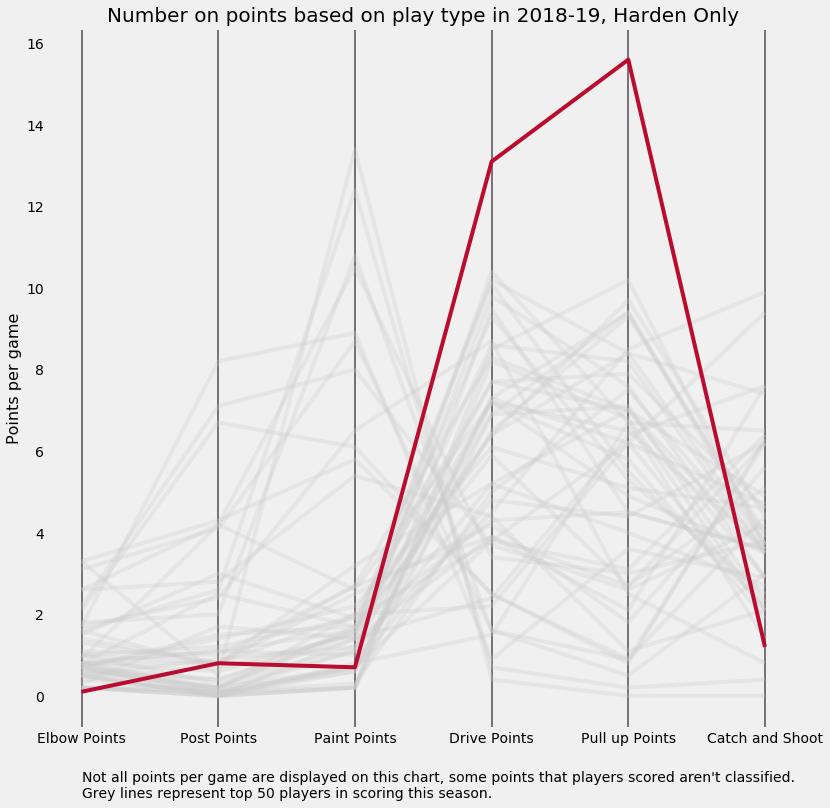

In [32]:
fig, ax = plt.subplots(figsize=(12, 12))

player = "James Harden"

plot_others(ax, players, player, melted_df)
plot_single_player(ax, player, color_mappings, melted_df)
set_ticks_labels(ax, "Number on points based on play type in 2018-19, Harden Only")

_ = ax.text(0, -2.5, "Not all points per game are displayed on this chart, "
        "some points that players scored aren't classified.\n"
        "Grey lines represent top 50 players in scoring this season.")
fig.savefig('images/scoring_type_harden_only.png', bbox_inches='tight')

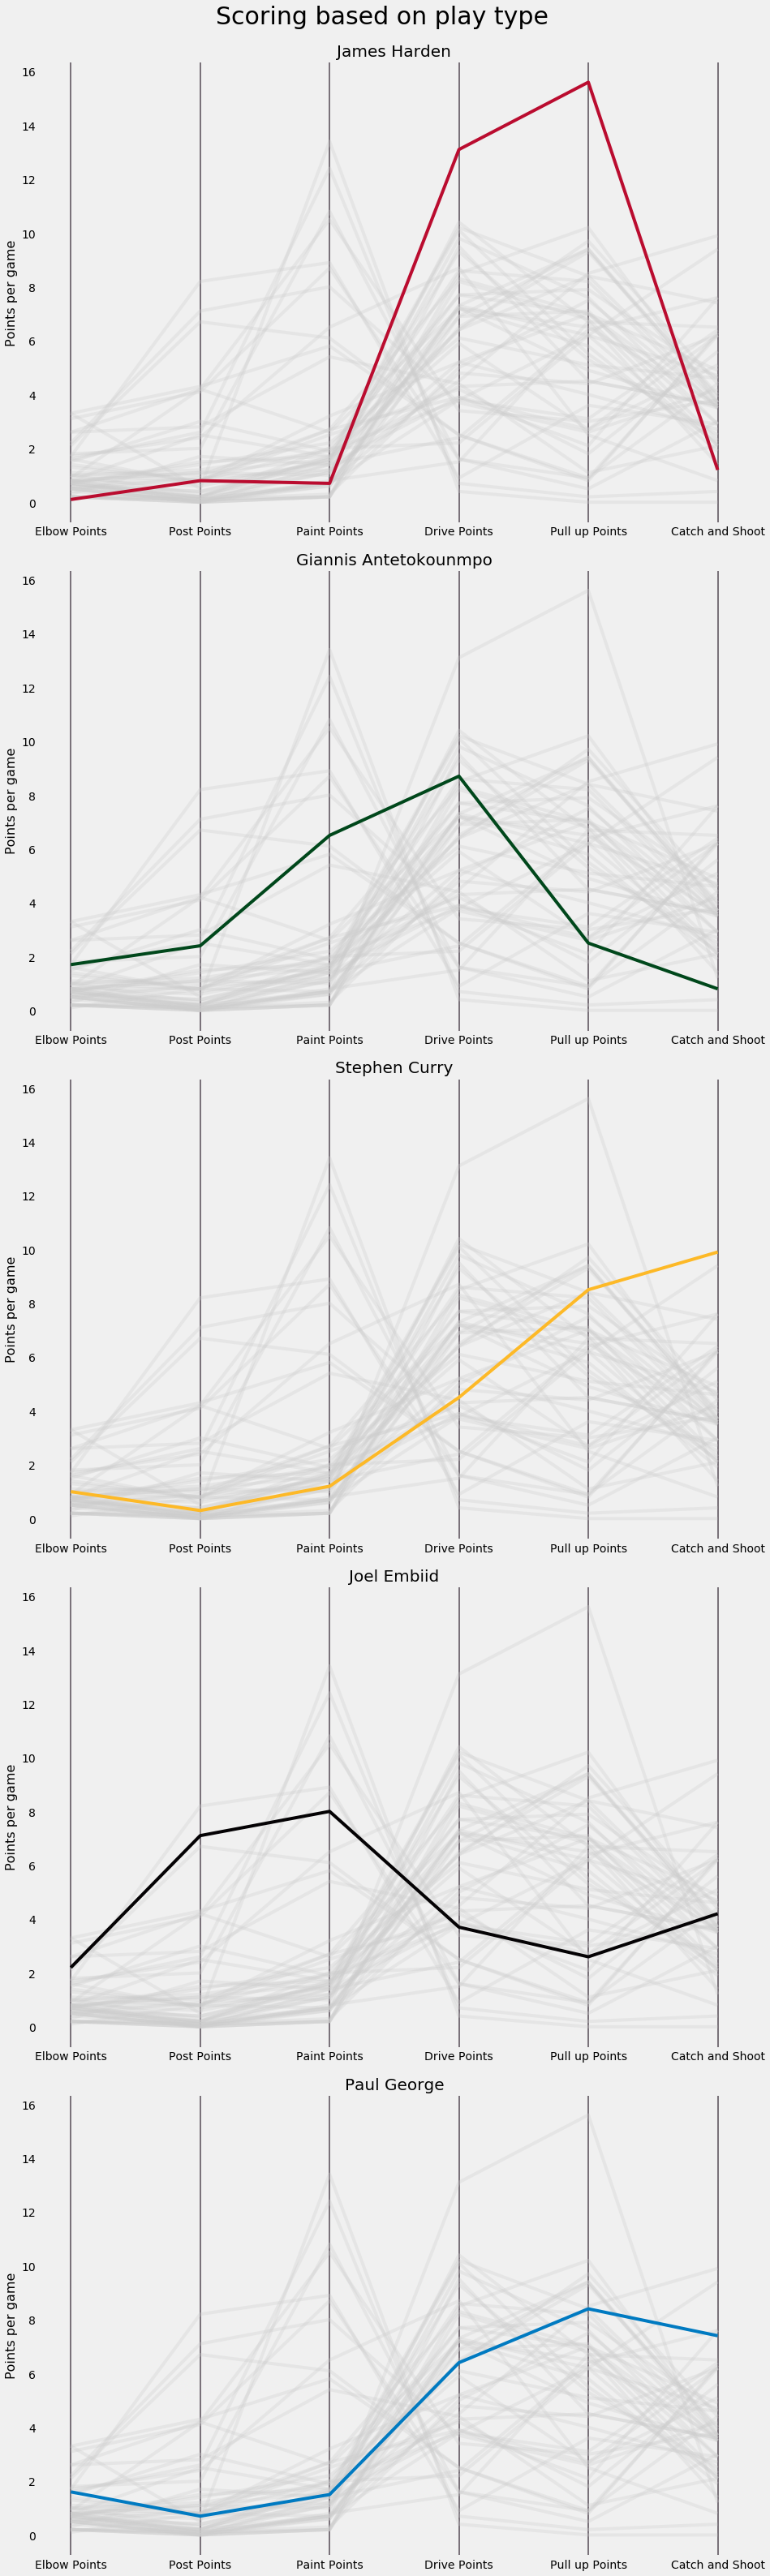

In [34]:
fig, axes = plt.subplots(5, 1, figsize=(14, 48))

keys = list(color_mappings.keys())

for i in range(len(keys)):
    player = keys[i]
    ax = axes.flatten()[i]
    
    
    plot_others(ax, players, player, melted_df)
    plot_single_player(ax, player, color_mappings, melted_df)
    set_ticks_labels(ax, player)
fig.suptitle("Scoring based on play type", fontsize=30)
fig.subplots_adjust(left=None, bottom=None, right=None, top=0.96, wspace=0.05, hspace=0.1)
fig.savefig('images/scoring_type_long.png', bbox_inches='tight')

## Only Houston players

In [20]:
houston_players_scoring = scoring_type_df.loc[scoring_type_df.TEAM_ABBREVIATION == "HOU"]

In [21]:
filtered_hou = filter_data_frame(houston_players_scoring)

In [22]:
player_list = list(filtered_hou.PLAYER_NAME.unique())

In [23]:
melted_hou = pd.melt(filtered_hou, id_vars='PLAYER_NAME')

In [24]:
houston_mapping = {
    'James Harden': '#CE1141',
    'Clint Capela': '#000000',
    'Chris Paul': '#FFC72C',
    'Eric Gordon': '#E56020',
    'Kenneth Faried': '#2C7AA1',
}

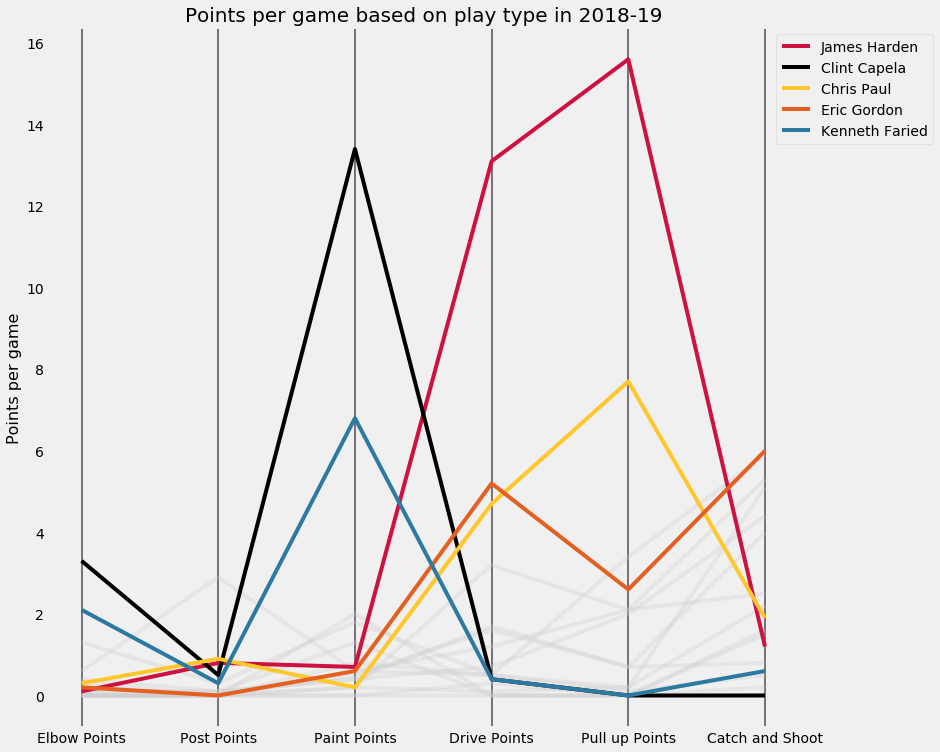

In [37]:
fig, ax = plt.subplots(figsize=(12, 12))


for player_name in player_list:
    if player_name in houston_mapping:
        continue
    current_player_data = melted_hou.loc[melted_hou.PLAYER_NAME == player_name]
    ax.plot('variable', 'value', data=current_player_data, color='#CDCDCD', alpha=0.3, label="")
    
for player_name in houston_mapping:
    current_player_data = melted_hou.loc[melted_hou.PLAYER_NAME == player_name]
    color = houston_mapping[player_name]
    ax.plot('variable', 'value', data=current_player_data, color=color, alpha=1.0, label=player_name)
ax.set_ylabel("Points per game", size=16)
ax.set_title("Points per game based on play type in 2018-19", size=20)
    
ax.set_xticklabels([
    "Elbow Points",
    "Post Points",
    "Paint Points",
    "Drive Points",
    "Pull up Points",
    "Catch and Shoot"
])

ax.grid(False, axis='y')
ax.grid(True, axis='x', color='#544953', linewidth=1.5)
ax.legend(bbox_to_anchor=(0.96, 1))
fig.savefig('images/houston_players_scoring.png', bbox_inches='tight')

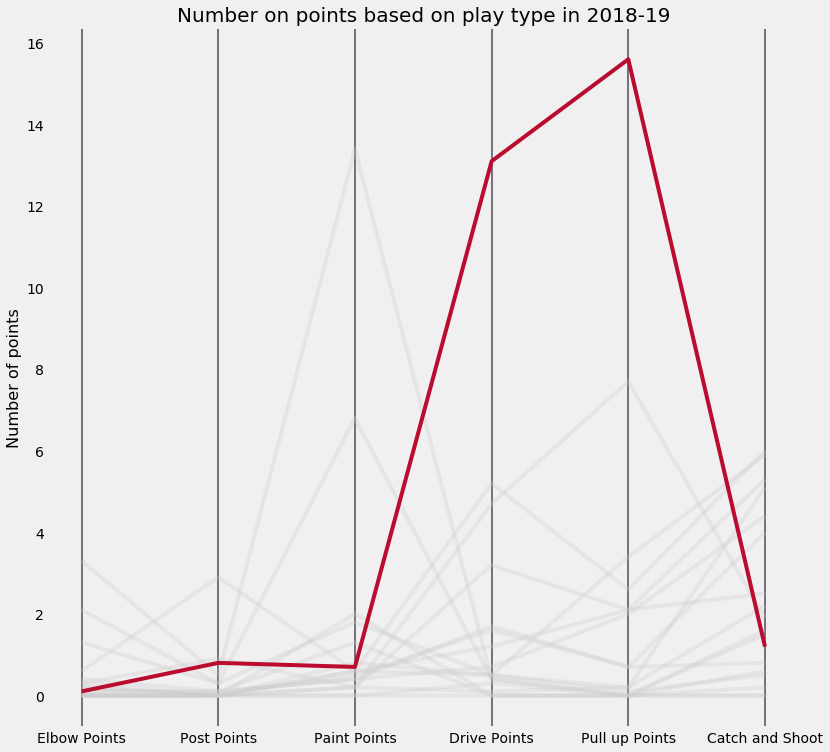

In [398]:
fig, ax = plt.subplots(figsize=(12, 12))

player = "James Harden"

plot_others(ax, player_list, player, melted_hou)
plot_single_player(ax, player, color_mappings, filtered_hou)
set_ticks_labels(ax, "Number on points based on play type in 2018-19")

Comments: Pretty straight forward team. There are only three players which create shots for themselves. Harden, Paul and Gordon do most of the work in terms of creation with Harden being much more ahead of everyone else. Capela and Faried have been doing the damage under the basket with easy dunks/layups and every other player is relying heavily on catch and shoot (with multiple players hovering around 4 PPG).

# Shot charts and shot analysis

## Shotchart methods

In [39]:
from collections import Counter
import operator
def create_bins(data_frame, bin_number_x = 30, bin_number_y=300 / (500.0 / 30.0), league_average = None,
                width = 500, height = 300, norm_x = 250, norm_y = 48):
    """
    Method which creates bins the dataset into squared grid. This is used so that plot looks nicer than the raw
    locations plot. Along with binning the data, the percentages per zones and for each bin are calculated here
    and added to the copy of data_frame object so they can be used for plotting later.

    :return: Returns the copied  data_frame pandas DataFrame object with additional info about the shots.
    """
    # Binned x and y coordinates
    x_bins, y_bins = [], []
    # Copying the dataset to add more data
    copied_df = data_frame.copy()
    # Keys are basically x_bin and y_bin
    keys = []
    # Counter of shots and shots made per locations
    location_counts, location_made = Counter(), Counter()
    # be found

    # Size of elements in bin, they should be the same
    bin_size_x = float(width) / float(bin_number_x)
    bin_size_y = float(height) / float(bin_number_y)
    # List for locations of shots
    locations_annotated = []
    # Counter of shots and shots made per zone
    zones_counts, zones_made = Counter(), Counter()

    # Maximum size of an element in one bin
    max_size = int((int(bin_size_x) - 1) * (int(bin_size_y) - 1))

    # Keys that are in restricted area will be stored here, this will be used for finding maximum number of shots
    restricted_area_keys = []

    # Dictionary which will determine the color of marker in bin
    percentage_color_dict = {}

    for i in range(len(data_frame)):

        # Row from data frame
        row = data_frame.iloc[i]

        x_shot_orig, y_shot_orig = row.LOC_X, row.LOC_Y

        # Normalize
        x_shot = x_shot_orig + norm_x  # to put minimum to zero
        y_shot = y_shot_orig + norm_y  # to put minimum to zero

        # bin_index = (x_shot / w) * bin_size
        curr_x_bin = 0 if x_shot == 0 else int((x_shot / float(width)) * bin_number_x)
        curr_y_bin = 0 if y_shot == 0 else int((y_shot / float(height)) * bin_number_y)

        # Key for dicts
        key = (curr_x_bin, curr_y_bin)

        if row.SHOT_ZONE_BASIC == "Restricted Area":
            restricted_area_keys.append(key)

        # Counting number of shots made and shots shot
        keys.append(key)
        location_counts[key] += 1
        location_made[key] += row.SHOT_MADE_FLAG

        basic_shot_zone, shot_zone_area = row.SHOT_ZONE_BASIC, row.SHOT_ZONE_AREA
        zone_dist = row.SHOT_ZONE_RANGE

        area_code = shot_zone_area.split("(")[1].split(")")[0]
        if "3" in basic_shot_zone:
            locations_annotated.append("3" + area_code)
        elif "Paint" in basic_shot_zone:
            locations_annotated.append("P" + area_code + zone_dist[0])
        elif "Mid" in basic_shot_zone:
            locations_annotated.append("M" + area_code + zone_dist[0])
        else:
            locations_annotated.append("R" + area_code)

        # Creating key for zones
        zone_key = (basic_shot_zone, shot_zone_area, zone_dist)

        # Counting the occurences based on both bin_key and zone_key, because of that we have dict in dict
        if key in percentage_color_dict:
            if zone_key in percentage_color_dict[key]:
                percentage_color_dict[key][zone_key] = percentage_color_dict[key][zone_key] + 1
            else:
                percentage_color_dict[key][zone_key] = 1
        else:
            percentage_color_dict[key] = {}
            percentage_color_dict[key][zone_key] = 1

        zones_counts[zone_key] += 1

        if row.SHOT_MADE_FLAG:
            zones_made[zone_key] += 1

    shot_locations_percentage = []  # percentage in given bin
    shot_locations_counts = []
    raw_counts = []
    # List which contains comparison for each shot with league average in that zone
    shot_comparison = []
    # List which contains comparison of player's shooting in zone vs league average
    per_zone_comparison = []
    per_zone_percentage = []

    # Finding the maximal number of shots from data
    non_ra = []
    for key in location_counts:
        if key not in restricted_area_keys:
            if location_counts[key] not in non_ra:
                non_ra.append(location_counts[key])

    sorted_non_ra = sorted(non_ra)
    max_out_of_restricted = float(sorted_non_ra[-1])

    for j in range(len(data_frame)):
        key = keys[j]
        x_bin, y_bin = key[0], key[1]
        shot_percent = float(location_made[key]) / location_counts[key]
        # shot_percent = np.clip(shot_percent, 0.3, 0.7)
        shot_locations_percentage.append(shot_percent * 100)
        if league_average is not None:
            # Getting info about zone
            # We are getting that info from
            per_zone_counter_from_percentage_color_dict = percentage_color_dict[key]
            zone_key = max(per_zone_counter_from_percentage_color_dict.items(),
                           key=operator.itemgetter(1))[0]

            shot_zone_basic = zone_key[0]
            shot_zone_area = zone_key[1]
            distance = zone_key[2]

            # Calculating the percentage in current zone
            zone_percent = 0.0 if zone_key not in zones_made else float(zones_made[zone_key]) / \
                                                                  float(zones_counts[zone_key])

            # Retrieving league average percentage for current zone
            avg_percentage = league_average.loc[
                (league_average.SHOT_ZONE_BASIC == shot_zone_basic) &
                (league_average.SHOT_ZONE_AREA == shot_zone_area) &
                (league_average.SHOT_ZONE_RANGE == distance)].FG_PCT.iloc[
                0
            ]
            # Comparison of league average and each shot
            shot_comparison.append(np.clip((shot_percent - avg_percentage) * 100, -10, 10))
            # Comparison of zone and league average
            per_zone_comparison.append(np.clip((zone_percent - avg_percentage) * 100, -10, 10))
            # Percentage of shot in current zone, kinda inaccurate info, good for some other type of plot
            per_zone_percentage.append(np.clip(zone_percent * 100, 35, 65))

        # Calculating value to which the markers will be scaled later on
        # The data in restricted is scaled to maximum out of restricted area, because players usually have a lot
        # more shots in restricted area
        value_to_scale = max_out_of_restricted if location_counts[key] > max_out_of_restricted else \
            location_counts[key]
        # Storing the data into a list
        shot_locations_counts.append((float(value_to_scale) / max_out_of_restricted) * max_size)

        # Count of shots per bin
        raw_counts.append(location_counts[key])

        # Middle of current and next bin is where we will place the marker in real coordinates
        unbinned_x = ((x_bin * float(width)) / bin_number_x + (
                (x_bin + 1) * float(width)) / bin_number_x) / 2 - norm_x
        unbinned_y = ((y_bin * float(height)) / bin_number_y + (
                (y_bin + 1) * float(height)) / bin_number_y) / 2 - norm_y

        # Adding binned locations
        x_bins.append(unbinned_x)
        y_bins.append(unbinned_y)

    # Binned locations
    copied_df['BIN_LOC_X'] = x_bins
    copied_df['BIN_LOC_Y'] = y_bins
    # Percentage comparison with league averages
    if league_average is not None:
        # Comparison of each shot with league average for that zone
        copied_df['PCT_LEAGUE_AVG_COMPARISON'] = shot_comparison
        # Comparison of each zone with league average for that zone
        copied_df['PCT_LEAGUE_COMPARISON_ZONE'] = per_zone_comparison
    # Percentage of shots for that location
    copied_df['LOC_PERCENTAGE'] = shot_locations_percentage
    # Percentage of whole zone (not in comparison with league average)
    copied_df['LOC_ZONE_PERCENTAGE'] = per_zone_percentage
    # Scaled count of shots and count of shots per bin
    copied_df['LOC_COUNTS'] = shot_locations_counts
    copied_df['LOC_RAW_COUNTS'] = raw_counts

    return copied_df

## Draw court

In [40]:
from matplotlib.patches import Circle, Rectangle, Arc

# Amazing function by Bradley Fay for plotting the nba court
# source: https://github.com/bradleyfay/py-Goldsberry/blob/master/docs/Visualizing%20NBA%20Shots%20with%20py-Goldsberry.ipynb
def draw_court(ax=None, color='black', lw=2, outer_lines=False):
    # If an axes object isn't provided to plot onto, just get current one
    if ax is None:
        ax = plt.gca()

    # Create the various parts of an NBA basketball court

    # Create the basketball hoop
    # Diameter of a hoop is 18" so it has a radius of 9", which is a value
    # 7.5 in our coordinate system
    hoop = Circle((0, 0), radius=7.5, linewidth=lw, color=color, fill=False)

    # Create backboard
    backboard = Rectangle((-30, -7.5), 60, -1, linewidth=lw, color=color)

    # The paint
    # Create the outer box 0f the paint, width=16ft, height=19ft
    outer_box = Rectangle((-80, -47.5), 160, 190, linewidth=lw, color=color,
                          fill=False, zorder=0)
    # Create the inner box of the paint, widt=12ft, height=19ft
    inner_box = Rectangle((-60, -47.5), 120, 190, linewidth=lw, color=color,
                          fill=False, zorder=0)

    # Create free throw top arc
    top_free_throw = Arc((0, 142.5), 120, 120, theta1=0, theta2=180,
                         linewidth=lw, color=color, fill=False, zorder=0)
    # Create free throw bottom arc
    bottom_free_throw = Arc((0, 142.5), 120, 120, theta1=180, theta2=0,
                            linewidth=lw, color=color, linestyle='dashed', zorder=0)
    # Restricted Zone, it is an arc with 4ft radius from center of the hoop
    restricted = Arc((0, 0), 80, 80, theta1=0, theta2=180, linewidth=lw,
                     color=color, zorder=0)

    # Three point line
    # Create the side 3pt lines, they are 14ft long before they begin to arc
    corner_three_a = Rectangle((-220, -47.5), 0, 138, linewidth=lw,
                               color=color, zorder=0)
    corner_three_b = Rectangle((220, -47.5), 0, 138, linewidth=lw, color=color, zorder=0)
    # 3pt arc - center of arc will be the hoop, arc is 23'9" away from hoop
    # I just played around with the theta values until they lined up with the 
    # threes
    three_arc = Arc((0, 0), 475, 475, theta1=22, theta2=158, linewidth=lw,
                    color=color, zorder=0)

    # Center Court
    center_outer_arc = Arc((0, 422.5), 120, 120, theta1=180, theta2=0,
                           linewidth=lw, color=color, zorder=0)
    center_inner_arc = Arc((0, 422.5), 40, 40, theta1=180, theta2=0,
                           linewidth=lw, color=color, zorder=0)

    # List of the court elements to be plotted onto the axes
    court_elements = [hoop, backboard, outer_box, inner_box, top_free_throw,
                      bottom_free_throw, restricted, corner_three_a,
                      corner_three_b, three_arc, center_outer_arc,
                      center_inner_arc]

    if outer_lines:
        # Draw the half court line, baseline and side out bound lines
        outer_lines = Rectangle((-250, -48), 500, 470, linewidth=lw,
                                color=color, fill=False)
        court_elements.append(outer_lines)

    # Add the court elements onto the axes
    for element in court_elements:
        ax.add_patch(element)

    return ax

## Draw binned shotchart

In [41]:
import matplotlib.path as mpath
def get_smooth_square():
    """
    Creates marker which represents smooth square.

    :return: new matplotlib.path.Path instance
    """
    marker = np.array([[-0.8, 1.0],
                       [-1.0, 0.8],
                       [-1.0, -0.8],
                       [-0.8, -1.0],
                       [0.8, -1.0],
                       [1.0, -0.8],
                       [1.0, 0.8],
                       [0.8, 1.0],
                       [-0.8, 1.0]])

    return mpath.Path(marker, closed=True)

def plot_shotchart(data_frame, title, image_name=None):
    plt.style.use('fivethirtyeight')
    fig, ax = plt.subplots(figsize=(12, 12))
    # colors_dict = {0:'red', 1:'green'}
    cmap = sns.blend_palette(colors=["#4159E1", "#B0E0E6", "#FFFF99","#EF3330", "#AB2020"], as_cmap=True)

    
    # LOC_PERCENTAGE -> total perc
    # PCT_LEAGUE_AVG_COMPARISON -> comparison per bins
    # PCT_LEAGUE_COMPARISON_ZONE -> comparison per zones only
    # LOC_X, LOC_Y -> real locs
    # BIN_LOC_X, BIN_LOC_Y -> binned locations
    marker = get_smooth_square()
    paths = ax.scatter(
        x=data_frame.BIN_LOC_X,
        y=data_frame.BIN_LOC_Y,
        marker=marker,
        s=data_frame.LOC_COUNTS * 2,
        c=data_frame.PCT_LEAGUE_COMPARISON_ZONE,
        cmap=cmap
    )

    """for i in range(len(cleared_df)):
        if cleared_df.iloc[i].LOCATION_CODE == "3C" or cleared_df.iloc[i].LOCATION_CODE == "RC":
            plt.text(x=cleared_df.iloc[i].LOC_X, y=cleared_df.iloc[i].LOC_Y, s=cleared_df.iloc[i].LOCATION_CODE, color="#E2E2FF")"""

    # Frequency

    ax.text(x=-240, y=360, s="Less\nFrequent", color="#E8E8FF", fontsize=12)
    ax.scatter(x=-218, y=377, s=20 * 1 * 2.5, marker=marker, c="#E8E8FF")
    ax.scatter(x=-205, y=377, s=20 * 3 * 2.5, marker=marker, c="#E8E8FF")
    ax.scatter(x=-190, y=377, s=20 * 6 * 2.5, marker=marker, c="#E8E8FF")
    ax.scatter(x=-171, y=377, s=20 * 9 * 2.5, marker=marker, c="#E8E8FF")
    ax.scatter(x=-151, y=377, s=20 * 11 * 2.5, marker=marker, c="#E8E8FF")
    ax.text(x=-153, y=360, s="      More\nFrequent", color="#E8E8FF", fontsize=12)


    # Efficiency

    ax.text(x=66, y=410, s="Comparison with league average percentage", color="#E8E8FF", fontsize=12)
    ax.text(x=95, y=360, s="Below\nAverage", color="#E8E8FF", fontsize=12)
    ax.scatter(x=130, y=377, s=550, marker=marker, c="#4159E1")
    ax.scatter(x=147, y=377, s=550, marker=marker, c="#B0E0E6")
    ax.scatter(x=164, y=377, s=550, marker=marker, c="#FFFF99")
    ax.scatter(x=181, y=377, s=550, marker=marker, c="#EF3330")
    ax.scatter(x=198, y=377, s=550, marker=marker, c="#AB2020")
    ax.text(x=201, y=360, s="   Above\nAverage", color="#E8E8FF", fontsize=12)

    # Changing court color
    ax.set_facecolor('#363F48')

    #plt.xticks(np.arange(-250, 251, 20))
    #plt.yticks(np.arange(-50, 490, 20))
    # Removing ticks
    ax.xaxis.set_ticks([])
    ax.yaxis.set_ticks([])
    ax.grid(False)

    # Title
    plt.title(title, size=20)
    
    # Drawing court
    draw_court(ax=ax,outer_lines=True, lw=3)
    ax.set_xlim(-251,251)
    ax.set_ylim(-65,423)

    if image_name:
        fig.savefig(image_name, bbox_inches='tight')

## Plot raw shotchart

In [42]:
def plot_raw_shotchart(data_frame, title, image_name=None):
    plt.style.use('fivethirtyeight')
    fig, ax = plt.subplots(figsize=(12, 12))
    
    green = '#45B056'
    red = '#B04556'
    
    made_shots = data_frame.loc[data_frame.SHOT_MADE_FLAG == 1]
    missed_shots = data_frame.loc[data_frame.SHOT_MADE_FLAG == 0]
    paths = ax.scatter(
        x=made_shots.LOC_X,
        y=made_shots.LOC_Y,
        marker='o',
        c=green,
        s=100
    )
    
    paths = ax.scatter(
        x=missed_shots.LOC_X,
        y=missed_shots.LOC_Y,
        marker='x',
        c=red,
        s=100
    )
        
    # Legend
    ax.scatter(x=-230, y=365, s=400, marker='o', c=green)
    ax.text(x=-215, y=363, s="Made", color=green, fontsize=18, ha='left', va='center')
    ax.scatter(x=185, y=365, s=400, marker='x', c=red)
    ax.text(x=200, y=363, s="Missed", color=red, fontsize=18, ha='left', va='center')
    
    # Changing court color
    ax.set_facecolor('#363F48')

    #plt.xticks(np.arange(-250, 251, 20))
    #plt.yticks(np.arange(-50, 490, 20))
    # Removing ticks
    ax.xaxis.set_ticks([])
    ax.yaxis.set_ticks([])
    ax.grid(False)

    # Title
    plt.title(title, size=20)
    
    # Drawing court
    draw_court(ax=ax,outer_lines=True, lw=3)
    ax.set_xlim(-251,251)
    ax.set_ylim(-65,423)
    
    if image_name:
        fig.savefig(image_name, bbox_inches='tight')

## Drawing

In [43]:
from nba_api.stats.endpoints.shotchartdetail import ShotChartDetail
from nba_api.stats.static.players import find_players_by_full_name

In [44]:
harden_shotchart = ShotChartDetail(team_id=0, player_id=harden_id, context_measure_simple='FGA', season_nullable='2018-19')

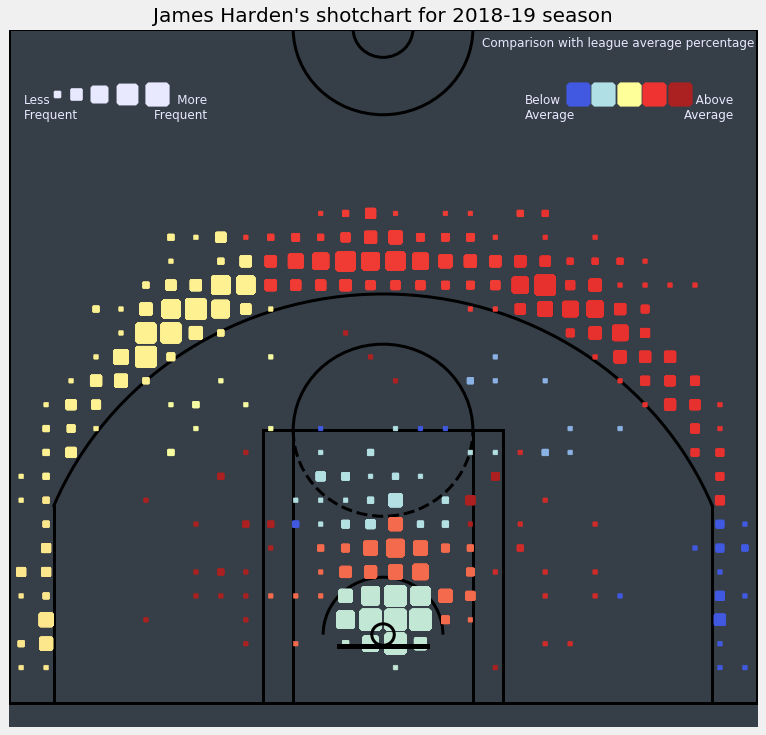

In [52]:
harden_df = harden_shotchart.get_data_frames()[0]
league_avg = harden_shotchart.get_data_frames()[1]

harden_df.LOC_X = -harden_df.LOC_X  # REAL DATA IS FLIPPED
harden_df = harden_df.loc[(harden_df.SHOT_ZONE_AREA != "Back Court(BC)")
                          & (harden_df.LOC_Y < 300)]  # drop shots that aren't close to the center

binned_df = create_bins(data_frame=harden_df, league_average=league_avg)

plot_shotchart(data_frame=binned_df, title="James Harden's shotchart for 2018-19 season",image_name='images/shotchart.png')

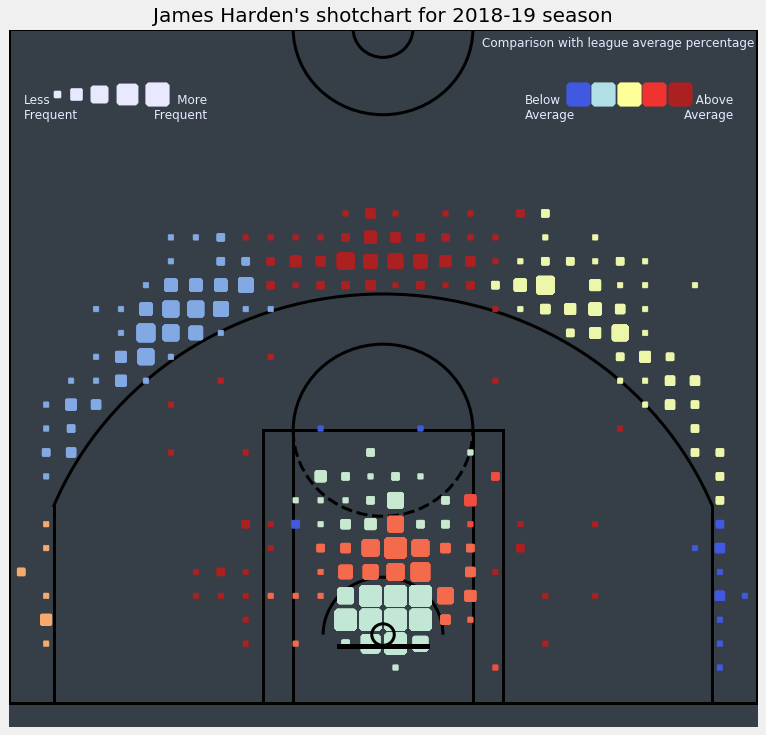

In [46]:
harden_df = harden_df.loc[harden_df.ACTION_TYPE != "Step Back Jump shot"]  # drop shots that aren't close to the center

binned_df = create_bins(data_frame=harden_df, league_average=league_avg)

plot_shotchart(data_frame=binned_df, title="James Harden's shotchart for 2018-19 season",image_name='images/shotchart.png')

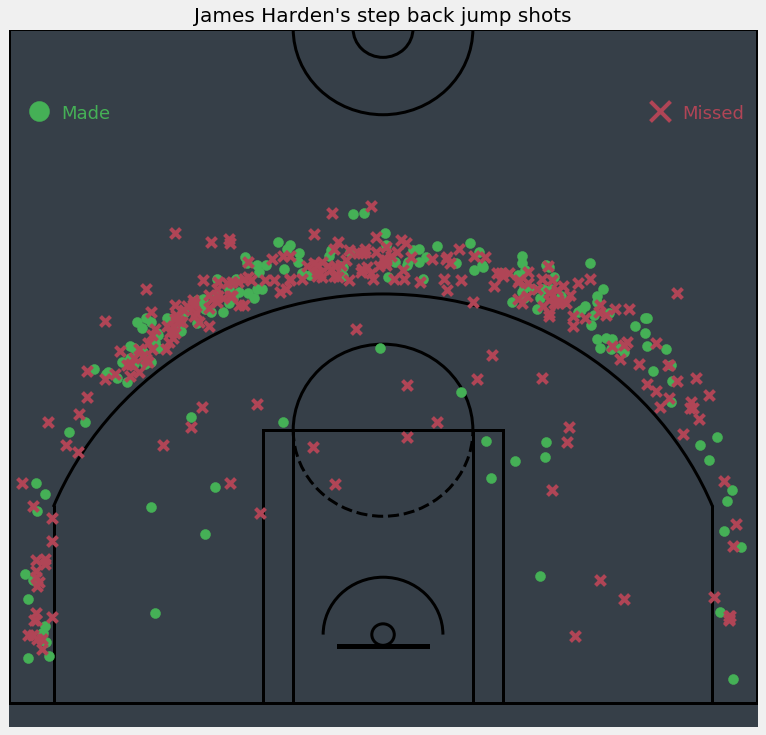

In [53]:
step_backs = harden_df.loc[harden_df.ACTION_TYPE == 'Step Back Jump shot']

plot_raw_shotchart(step_backs, 'James Harden\'s step back jump shots',image_name='images/raw_step.png')

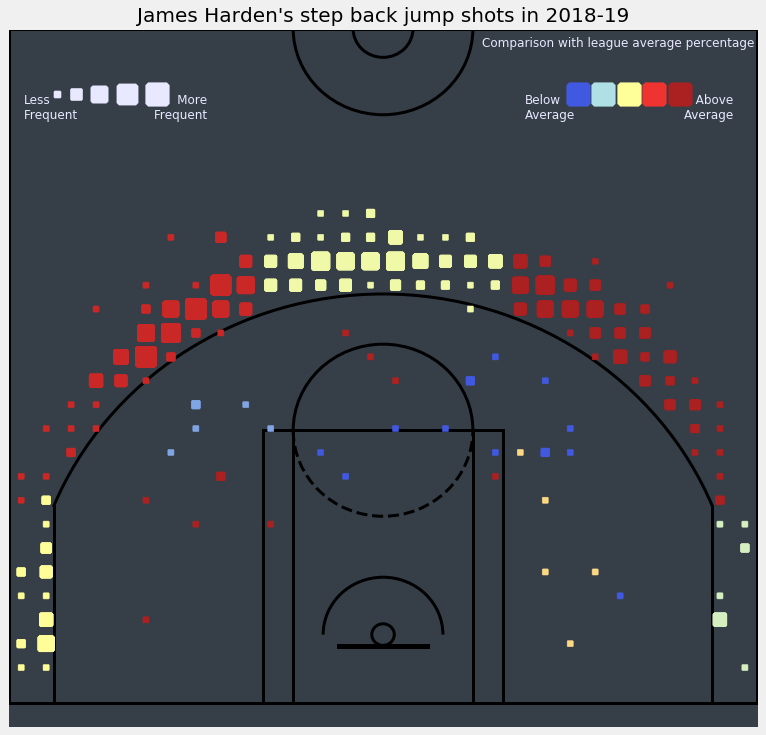

In [54]:
league_avg = harden_shotchart.get_data_frames()[1]

step_backs = step_backs.loc[step_backs.SHOT_ZONE_AREA != "Back Court(BC)"]  # drop shots that aren't close to the center

binned_df = create_bins(data_frame=step_backs, league_average=league_avg)

plot_shotchart(binned_df, 'James Harden\'s step back jump shots in 2018-19',image_name='images/step_shotchart.png')

**NOTE**: The comparison with league is on **ALL SHOTS**, not just step backs. So this is kind off crazy. That made me look how would he rank up with all other three point shooters BUT Only looking at Step back jumpers.

## Step Back Jumper - The unstoppable move

In [126]:
from nba_api.stats.endpoints.leaguedashplayerstats import LeagueDashPlayerStats

In [127]:
base_stats = LeagueDashPlayerStats(measure_type_detailed_defense='Base', per_mode_detailed='Totals')

In [128]:
base_df = base_stats.get_data_frames()[0]

In [129]:
from nba_api.stats.endpoints.playerdashboardbyshootingsplits import PlayerDashboardByShootingSplits

In [130]:
data_harden = PlayerDashboardByShootingSplits(player_id=harden_id)

In [131]:
harden_data_df = data_harden.get_data_frames()[-2]

In [132]:
base_df = base_df.sort_values(by='FG3M', ascending=False)

In [133]:
filtered_shooters = base_df.iloc[:100]
filtered_shooters = filtered_shooters.loc[filtered_shooters.PLAYER_ID != harden_id]

In [134]:
step_backs = harden_data_df.loc[harden_data_df.GROUP_VALUE == 'Step Back Jump shot']

In [135]:
top_10 = filtered_shooters.iloc[:10]

In [136]:
from adjustText import adjust_text

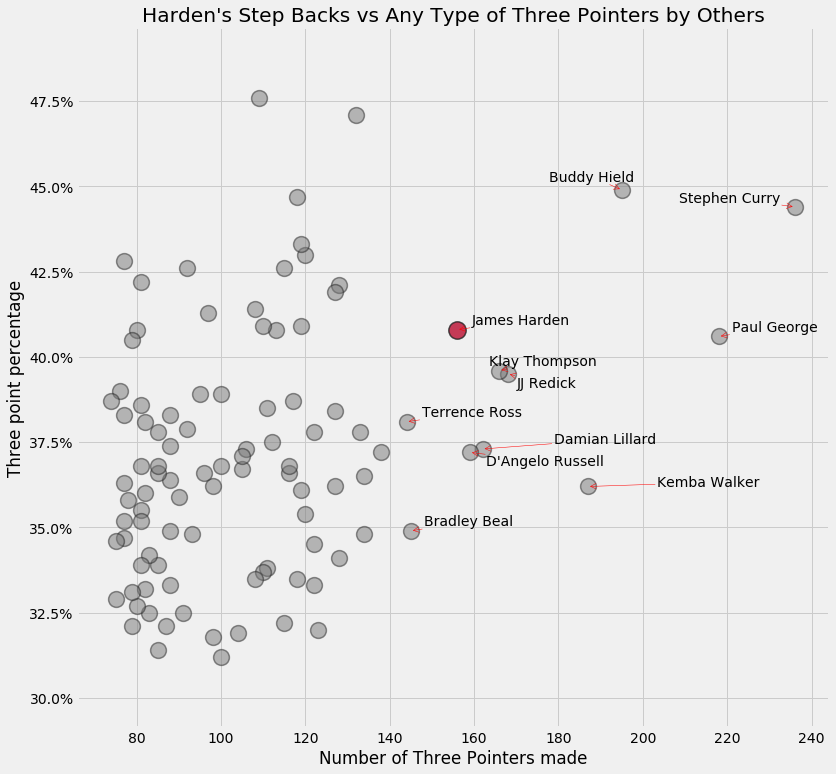

In [137]:
plt.style.use('fivethirtyeight')
fig, ax = plt.subplots(figsize=(12, 12))

size = 250

ax.scatter(
    x=filtered_shooters.FG3M,
    y=filtered_shooters.FG3_PCT,
    s=size,
    alpha=0.5,
    color="#787878",
    edgecolors="#232323",
    linewidths=1.5,
)

ax.scatter(
    x=step_backs.FG3M,
    y=step_backs.FG3_PCT,
    s=size+50,
    color="#BA0C2F",
    linewidths=1.5,
    alpha=0.8,
    edgecolors="#232323",
)

texts = []

for i in range(len(top_10)):
    item = top_10.iloc[i]
    texts.append(
        ax.text(
            x=item.FG3M,
            y=item.FG3_PCT,
            s=item.PLAYER_NAME
        )
    )

texts.append(
    ax.text(
        x=step_backs.FG3M.iloc[0],
        y=step_backs.FG3_PCT.iloc[0],
        s="James Harden"
    )
)
    
adjust_text(texts, arrowprops=dict(arrowstyle='->', color='red'), expand_points=(1.3, 1.3), expand_text=(1.5, 1.5))

ax.set_yticklabels(["{0:.1f}%".format(item*100) for item in ax.get_yticks()])
ax.set_xlabel("Number of Three Pointers made")
ax.set_ylabel("Three point percentage")

_ = ax.set_title("Harden's Step Backs vs Any Type of Three Pointers by Others")
fig.savefig('images/harden_step_back_other.png', bbox_inches='tight')

## Assist chart

In [383]:
import time
import requests

In [384]:
from nba_api.stats.endpoints.teamgamelog import TeamGameLog

In [385]:
from nba_api.stats.static.players import find_player_by_id

In [386]:
houston_id = 1610612745

In [387]:
houston_log = TeamGameLog(team_id=houston_id)
houston_df = houston_log.get_data_frames()[0]

In [388]:
pbp_base = "http://data.nba.com/data/10s/v2015/json/mobile_teams/nba/2018/scores/pbp/"
pbp_ext = "_full_pbp.json"

In [389]:
headers = {
    'User-Agent': 'Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/41.0.2227.0 Safari/537.36'
}

In [390]:
pbp_data = None

# THIS IS INTENSE ON WEB, DO NOT CALL IT, I SCRAPED IT ALREADY.
"""
for i in range(len(houston_df)):
    item = houston_df.iloc[i]
    url = pbp_base + str(item.Game_ID) + pbp_ext
    response = requests.get(url, headers=headers)
    json_data = response.json()
    game_events = json_data['g']['pd']
    for i in range(len(game_events)):
        cur_period_events = game_events[i]['pla']
        pd_df = pd.DataFrame(cur_period_events)
        if pbp_data is None:
            pbp_data = pd_df
        else:
            pbp_data = pd.concat([pbp_data, pd_df], ignore_index=True)
    time.sleep(2)
"""
pbp_data = pd.read_csv('houston_pbp_data.csv')

In [391]:
pbp_data.to_csv('houston_pbp_data.csv')

In [392]:
pbp_data.locX = -pbp_data.locX
basket_made_events = pbp_data.loc[pbp_data.etype == 1]


In [393]:
df = pd.DataFrame(response.json()['g']['pd'][1]['pla'])
df_2 = pd.DataFrame(response.json()['g']['pd'][2]['pla'])

In [394]:
harden_assists = basket_made_events.loc[basket_made_events.epid==harden_id]

In [395]:
player_names = []
for player_id in harden_assists.pid.tolist():
    if 1629109 == player_id:
        player_name = 'Gary Clark'
    else:
        player_name = find_player_by_id(player_id)['full_name']
    player_names.append(player_name)

In [396]:
harden_assists.loc[:, 'Player_Name'] = player_names

/home/daniel/.local/lib/python3.6/site-packages/pandas/core/indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
/home/daniel/.local/lib/python3.6/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [397]:
def plot_assist_chart(data_frame, title, ax, color):
    paths = ax.scatter(
        x=data_frame.locX,
        y=data_frame.locY,
        marker='o',
        c=color,
        s=150
    )
    
    ax.set_facecolor('#363F48')

    ax.xaxis.set_ticks([])
    ax.yaxis.set_ticks([])
    ax.grid(False)

    # Title
    ax.set_title(title, size=24)
    
    # Drawing court
    draw_court(ax=ax,outer_lines=True, lw=3)
    ax.set_xlim(-251,251)
    ax.set_ylim(-65,300)
    

In [398]:
players_dict = {
    'Clint Capela': '#CE1141',
    'PJ Tucker': '#000000',
    'Eric Gordon': '#C4CED4',
    'Gerald Green': '#8A8D8F',
    'James Ennis III': '#FFC72C',
    'Kenneth Faried': '#2C7AA1',
}

In [399]:
filtered_assists = harden_assists.loc[harden_assists.Player_Name.isin(list(players_dict.keys()))]

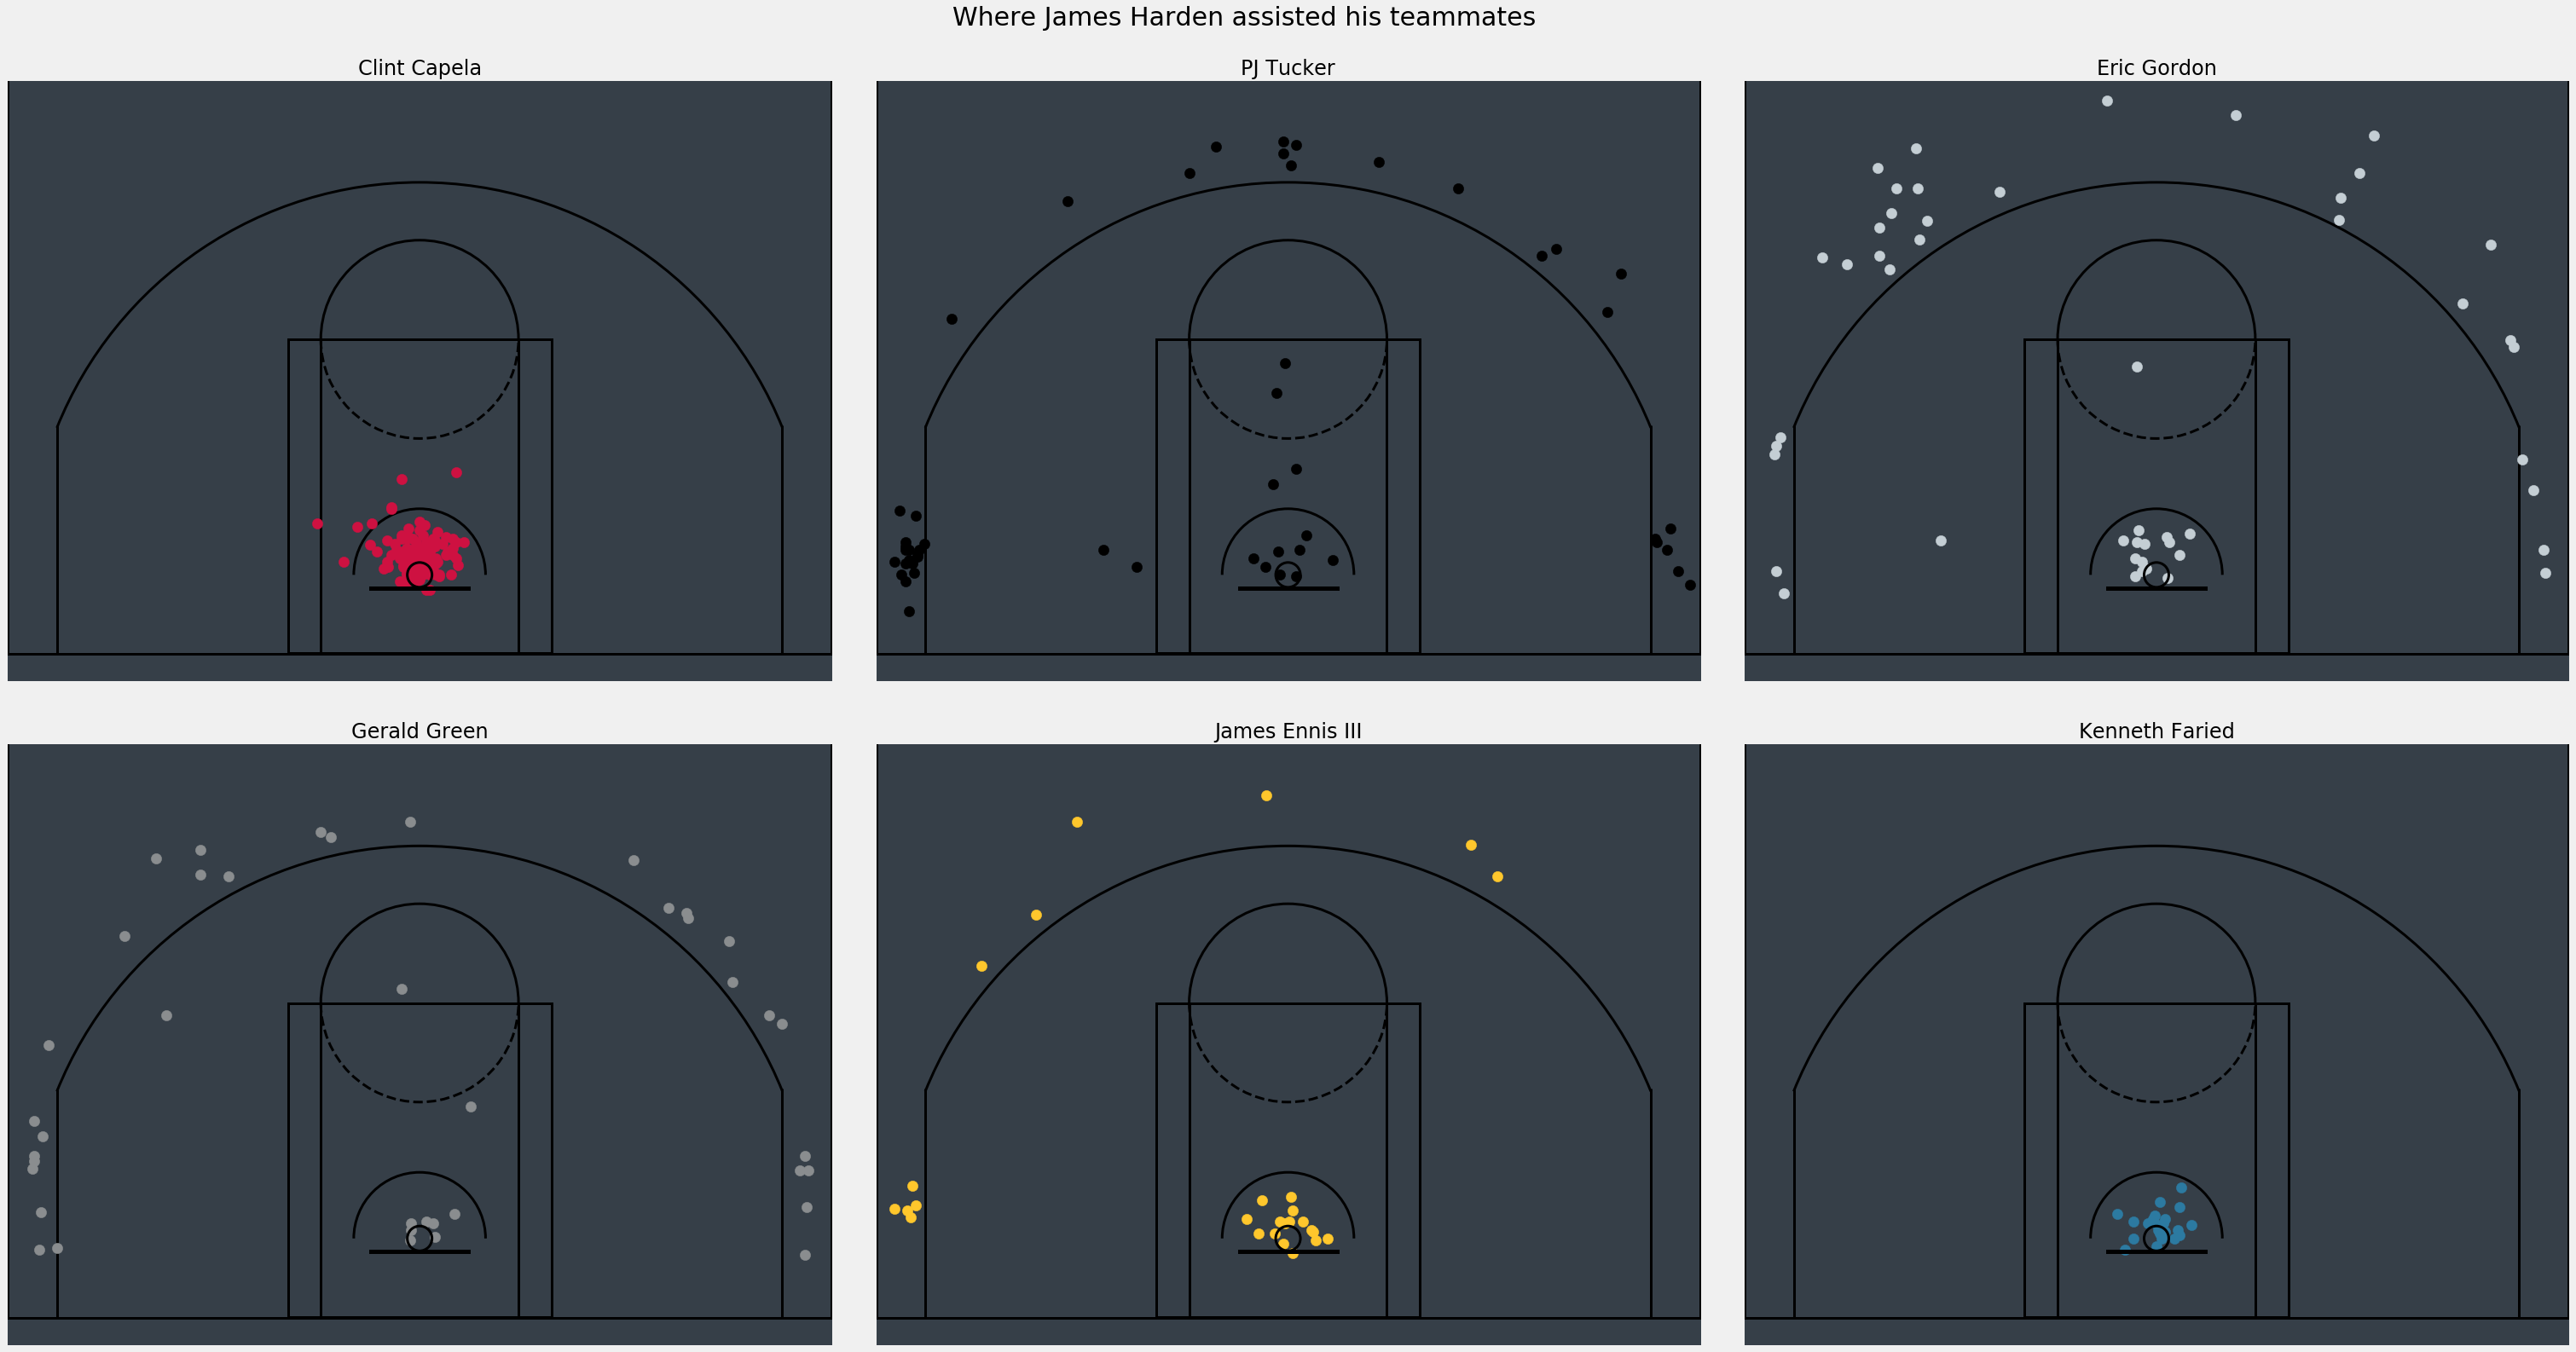

In [401]:
fig, axes = plt.subplots(2, 3, figsize=(48, 24))

flat_axes = axes.flatten()

for i, key in enumerate(players_dict):
    ax = flat_axes[i]
    player_shots = filtered_assists.loc[filtered_assists.Player_Name == key]
    plot_assist_chart(player_shots, f"{key}", ax, players_dict[key])

fig.suptitle("Where James Harden assisted his teammates", fontsize=30)
# fig.tight_layout()
fig.subplots_adjust(left=None, bottom=None, right=None, top=0.93, wspace=0.05, hspace=0.1)
fig.savefig('images/assist_charts.png', bbox_inches='tight')